In [1]:
import sys

sys.path.append("/data/idvor/python_scripts/")
import analysis
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.transforms import Bbox
import pandas as pd
import scipy.stats as st
import seaborn as sns
import math
import pingouin as pg

2023-10-01 11:50:53.542295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-01 11:50:55.035722: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-01 11:50:55.035789: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-10-01 11:50:55.035796: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
def bootstrapCI(x, nSamples=1000):
    means = np.array([np.nanmean(np.random.choice(x, len(x))) for i in range(nSamples)])
    means = np.sort(means)
    return means[int(nSamples * 0.025)], means[int(nSamples * 0.975)]


def quickCI(x):
    return np.percentile(x, 2.5), np.percentile(x, 97.5)


peaRsaColor = "#6AFC8F"
eucRsaColor = "#6CA7E6"
speRsaColor = "#D86AFC"
ckaColor = "#F55A27"
ccaColor = "#F5E750"
funNames = ["peaRsa", "eucRsa", "speRsa", "cca", "cka"]
rsaMetrics = ["peaRsa", "eucRsa", "speRsa"]

# Calculate golden ratio against 3 inches
plotHeight = 3
plotWidth = plotHeight * (1 + 5**0.5) / 2

In [3]:
trainingTraj = pd.read_csv("../outputs/masterOutput/trainingTraj.csv")
finalAcc = trainingTraj["valAcc"].loc[trainingTraj["epoch"] == 349]
print("Accuracy Mean: " + str(np.mean(finalAcc)))
print("Accuracy 95CI: " + str(pg.mad(finalAcc)))
print(f"Accuracy Range: {np.min(finalAcc)} - {np.max(finalAcc)}")

Accuracy Mean: 0.908897
Accuracy 95CI: 0.0020015129949826713
Accuracy Range: 0.9011 - 0.9143


In [4]:
modelPath = "../outputs/masterOutput/models/w0s0.pb"
print("Loading model")
model = tf.keras.models.load_model(modelPath)
model.summary()

Loading model


2023-10-01 11:51:02.344897: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-01 11:51:02.352964: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-01 11:51:02.353583: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-01 11:51:02.354610: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 96)        2688      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 96)        83040     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 96)        83040     
                                                                 
 dropout (Dropout)           (None, 16, 16, 96)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 192)       166080    
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 192)       331968    
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 192)         3

In [5]:
# Names: peaRsa,eucRsa,speRsa,svcca,cka
corres = pd.read_csv("../outputs/masterOutput/correspondence.csv", index_col=0)
corres = corres.loc[corres["peaRsa"] != -1]
corres["peaRsaCorr"] = corres["peaRsa"] == corres["layer"]
corres["eucRsaCorr"] = corres["eucRsa"] == corres["layer"]
corres["speRsaCorr"] = corres["speRsa"] == corres["layer"]

# Need to calculate cca and cka accuracy carefully as layers 9 and 8 are equivalent
corres["ccaCorr"] = corres["cca"] == corres["layer"]
corres["ckaCorr"] = corres["cka"] == corres["layer"]
corres.loc[corres["layer"] == 8, "ckaCorr"] = np.isin(
    corres["cka"].loc[corres["layer"] == 8], [8, 9]
)

peaRsaAcc = np.sum(corres["peaRsaCorr"]) / len(corres["peaRsaCorr"])
eucRsaAcc = np.sum(corres["eucRsaCorr"]) / len(corres["eucRsaCorr"])
speRsaAcc = np.sum(corres["speRsaCorr"]) / len(corres["speRsaCorr"])
ckaAcc = np.sum(corres["ckaCorr"].loc[corres["layer"] != 9]) / len(
    corres["ckaCorr"].loc[corres["layer"] != 9]
)

# Remove layer eight
corres = corres.loc[corres["layer"] != 8]
# Shift layer 9 and 10 down
corres.loc[corres["layer"] == 9, "layer"] = 8
corres.loc[corres["layer"] == 10, "layer"] = 9

# Shift metric answers down as well
corres.loc[corres["peaRsa"] == 9, "peaRsa"] = 8
corres.loc[corres["eucRsa"] == 9, "eucRsa"] = 8
corres.loc[corres["speRsa"] == 9, "speRsa"] = 8
corres.loc[corres["cka"] == 9, "cka"] = 8

corres.loc[corres["peaRsa"] == 10, "peaRsa"] = 9
corres.loc[corres["eucRsa"] == 10, "eucRsa"] = 9
corres.loc[corres["speRsa"] == 10, "speRsa"] = 9
corres.loc[corres["cka"] == 10, "cka"] = 9

# Increment layers
# corres['layer'] += 1
# corres['peaRsa'] += 1
# corres['eucRsa'] += 1
# corres['speRsa'] += 1
# corres['cka'] += 1

# Fix indices
corres.index = corres["layer"]

corres.head()

,model1,model2,peaRsa,eucRsa,speRsa,cca,cka,layer,peaRsaCorr,eucRsaCorr,speRsaCorr,ccaCorr,ckaCorr
layer,,,,,,,,,,,,,
0,w6s2,w0s3,0,0,0,0,0,0,True,True,True,True,True
1,w6s2,w0s3,1,1,1,3,1,1,True,True,True,False,True
2,w6s2,w0s3,2,2,2,3,2,2,True,True,True,False,True
3,w6s2,w0s3,3,3,2,9,3,3,True,True,False,False,True
4,w6s2,w0s3,4,4,1,9,4,4,True,True,False,False,True


In [6]:
pwccaCorres = pd.read_csv(
    "../outputs/masterOutput/pwccaCorrespondence.csv", index_col=0
)
pwccaCorres["pwccaCorr"] = pwccaCorres["pwcca"] == pwccaCorres["layer"]
pwccaCorres.loc[pwccaCorres["layer"] == 8, "pwccaCorr"] = np.isin(
    pwccaCorres["pwccaCorr"].loc[pwccaCorres["layer"] == 8], [8, 9]
)

pwccaAcc = np.sum(pwccaCorres["pwccaCorr"].loc[pwccaCorres["layer"] != 9]) / len(
    pwccaCorres["pwccaCorr"].loc[pwccaCorres["layer"] != 9]
)


# Remove layer eight
pwccaCorres = pwccaCorres.loc[pwccaCorres["layer"] != 8]
# Shift layer 9 and 10 down
pwccaCorres.loc[pwccaCorres["layer"] == 9, "layer"] = 8
pwccaCorres.loc[pwccaCorres["layer"] == 10, "layer"] = 9

# Shift metric answers down as well
pwccaCorres.loc[pwccaCorres["pwcca"] == 9, "pwcca"] = 8
pwccaCorres.loc[pwccaCorres["pwcca"] == 10, "pwcca"] = 9
pwccaCorres.index = pwccaCorres["layer"]

# Add one to every layer to index from 1
# pwccaCorres['layer'] += 1
# pwccaCorres['pwcca'] += 1

In [7]:
print(f"Pearson RSA Correspondence Test Accuracy: {np.round(peaRsaAcc, decimals = 2)}")
print(
    f"Euclidean RSA Correspondence Test Accuracy: {np.round(eucRsaAcc, decimals = 2)}"
)
print(f"Spearman RSA Correspondence Test Accuracy: {np.round(speRsaAcc, decimals = 2)}")
print(f"PWCCA Correspondence Test Accuracy: {np.round(pwccaAcc, decimals = 2)}")
print(f"CKA Correspondence Test Accuracy: {np.round(ckaAcc, decimals = 2)}")

Pearson RSA Correspondence Test Accuracy: 0.99
Euclidean RSA Correspondence Test Accuracy: 0.99
Spearman RSA Correspondence Test Accuracy: 0.79
PWCCA Correspondence Test Accuracy: 0.23
CKA Correspondence Test Accuracy: 0.99


In [8]:
layers = np.unique(corres["layer"])
# Remove last 2 layers
layers = layers[:-2]
peaRsaConfusion = np.zeros((len(layers), len(layers)))
for i, layer in enumerate(layers):
    tmp = corres["peaRsa"].loc[corres["layer"] == layer].value_counts()
    for index in tmp.index:
        # Continue if index is higher than shape
        if index >= len(layers):
            continue

        peaRsaConfusion[i, index] = tmp[index]
        peaRsaConfusion[index, i] = tmp[index]

peaRsaConfusion /= 937

In [9]:
eucRsaConfusion = np.zeros((len(layers), len(layers)))
for i, layer in enumerate(layers):
    tmp = corres["eucRsa"].loc[corres["layer"] == layer].value_counts()
    for index in tmp.index:
        # Continue if index is higher than shape
        if index >= len(layers):
            continue

        eucRsaConfusion[i, index] = tmp[index]
        eucRsaConfusion[index, i] = tmp[index]

eucRsaConfusion /= 937

In [10]:
speRsaConfusion = np.zeros((len(layers), len(layers)))
for i, layer in enumerate(layers):
    tmp = corres["speRsa"].loc[corres["layer"] == layer].value_counts()
    for index in tmp.index:
        # Continue if index is higher than shape
        if index >= len(layers):
            continue

        speRsaConfusion[layer, index] = tmp[index]
        speRsaConfusion[index, i] = tmp[index]

speRsaConfusion /= 937

In [11]:
ccaConfusion = np.zeros((len(layers), len(layers)))
for i, layer in enumerate(layers):
    tmp = pwccaCorres["pwcca"].loc[pwccaCorres["layer"] == layer].value_counts()
    for index in tmp.index:
        # Continue if index is higher than shape
        if index >= len(layers):
            continue

        ccaConfusion[i, index] = tmp[index]
        ccaConfusion[index, i] = tmp[index]

ccaConfusion /= 937

In [12]:
ckaConfusion = np.zeros((len(layers), len(layers)))
for i, layer in enumerate(layers):
    tmp = corres["cka"].loc[corres["layer"] == layer].value_counts()
    for index in tmp.index:
        # Continue if index is higher than shape
        if index >= len(layers):
            continue

        ckaConfusion[i, index] = tmp[index]
        ckaConfusion[index, i] = tmp[index]

ckaConfusion /= 937

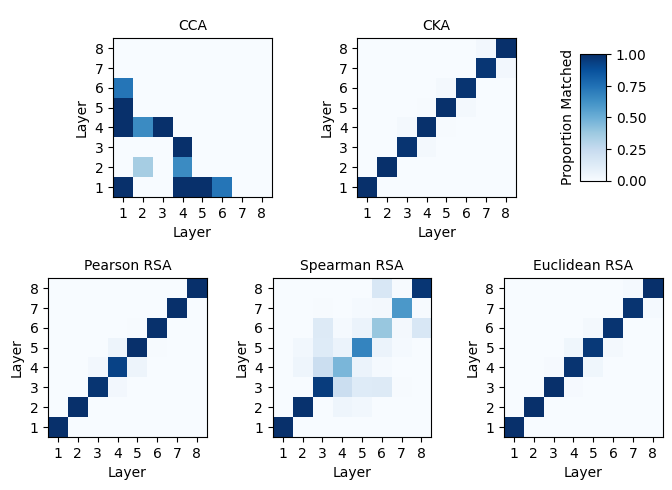

In [13]:
def plot_corr(ax, mat, title, xlabel=False, ylabel=False):
    ax.imshow(np.rot90(mat), cmap="Blues")
    ax.set_title(title, fontsize=10)
    ax.set_xticks(np.arange(0, 8, 1))
    ax.set_yticks(np.arange(0, 8, 1))
    ax.set_xticklabels(np.arange(1, 9, 1))
    ax.set_yticklabels(np.abs(np.arange(1, 9, 1) - 9))
    ax.set(adjustable="box", aspect="equal")

    if xlabel:
        ax.set_xlabel("Layer")
    if ylabel:
        ax.set_ylabel("Layer")


# Create 5x1 supblots
fig, axs = plt.subplots(2, 3, figsize=(6.5, 5.5))

plot_corr(axs[1][0], peaRsaConfusion, "Pearson RSA", xlabel=True, ylabel=True)
plot_corr(axs[1][1], speRsaConfusion, "Spearman RSA", xlabel=True, ylabel=True)
plot_corr(axs[1][2], eucRsaConfusion, "Euclidean RSA", xlabel=True, ylabel=True)
plot_corr(axs[0][0], ccaConfusion, "CCA", xlabel=True, ylabel=True)
plot_corr(axs[0][1], ckaConfusion, "CKA", xlabel=True, ylabel=True)
fig.subplots_adjust(wspace=0.25, hspace=0.5)
# Make the top right subplot invisible
axs[0][2].axis("off")

# Change to tight
plt.tight_layout()

# Add colorbar to the top right subplot
cbar_ax = fig.add_axes([0.85, 0.65, 0.04, 0.23])
fig.colorbar(axs[1][0].images[0], cax=cbar_ax)

# Add annotation
axs[0][2].annotate(
    "Proportion Matched",
    xy=(0.26, 0.5),
    xytext=(0.36, 0.2),
    rotation=90,
    xycoords="axes fraction",
)

# Move the CCA plot
pos = axs[0][0].get_position()
axs[0][0].set_position([pos.x0 + 0.05, pos.y0, pos.width, pos.height])

# Move the CKA plot
pos = axs[0][1].get_position()
axs[0][1].set_position([pos.x0 + 0.10, pos.y0, pos.width, pos.height])

# Move the peaRsa plot
pos = axs[1][0].get_position()
axs[1][0].set_position([pos.x0 - 0.05, pos.y0 + 0.05, pos.width, pos.height])

# Move the speRsa plot
pos = axs[1][1].get_position()
axs[1][1].set_position([pos.x0 - 0.03, pos.y0 + 0.05, pos.width, pos.height])

# Move the eucRsa plot
pos = axs[1][2].get_position()
axs[1][2].set_position([pos.x0, pos.y0 + 0.05, pos.width, pos.height])


fig.show()

# Export image
fig.savefig(f"../outputs/masterOutput/manuscriptFigures/correspondence.png")

In [14]:
rsaMetrics = ["peaRsa", "eucRsa", "speRsa"]
sanityPath = "../outputs/masterOutput/sanityCheckSims.csv"
sanityCKA2Path = "../outputs/masterOutput/sanityCheckCKA2.csv"
sanityCCAPath = "../outputs/masterOutput/pwccaSanity.csv"
tmp = pd.read_csv(sanityCKA2Path, index_col=0)
ccaTmp = pd.read_csv(sanityCCAPath, index_col=0)
sanityData = pd.read_csv(sanityPath, index_col=0)
sanityData["cca"] = ccaTmp["pwcca"]
sanityData[rsaMetrics] = sanityData[rsaMetrics] ** 2

permutePath = "../outputs/masterOutput/permuteSims.csv"
permuteData = pd.read_csv(permutePath)
permuteCKA2Path = "../outputs/masterOutput/permuteSimsCKA2.csv"
permuteCCAPath = "../outputs/masterOutput/pwccaSimulation.csv"
tmp = pd.read_csv(permuteCKA2Path, index_col=0)
tmp.index = permuteData.index
ccaTmp = pd.read_csv(permuteCCAPath, index_col=0)
ccaTmp.index = permuteData.index
permuteData["cca"] = ccaTmp["pwcca"]
permuteData[rsaMetrics] = permuteData[rsaMetrics] ** 2

print(
    f"Sanity Test",
    f"Pearson RSA -- mean {np.mean(sanityData['peaRsa'])}",
    f"SD {pg.mad(sanityData['peaRsa'])}",
    f"Eucliean RSA -- mean {np.mean(sanityData['eucRsa'])}",
    f"SD {pg.mad(sanityData['eucRsa'])}",
    f"Spearman RSA -- mean {np.mean(sanityData['speRsa'])}",
    f"SD {pg.mad(sanityData['speRsa'])}",
    f"CCA -- mean {np.mean(sanityData['cca'])}",
    f"SD {pg.mad(sanityData['cca'])}",
    f"CKA -- mean {np.mean(sanityData['cka'])}",
    f"SD {pg.mad(sanityData['cka'])}",
    "",
    f"Random Test",
    f"Pearson RSA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'random', 'peaRsa'])}",
    f"SD {pg.mad(permuteData.loc[permuteData['analysis'] == 'random', 'peaRsa'])}",
    f"Euclidean RSA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'random', 'eucRsa'])}",
    f"SD {pg.mad(permuteData.loc[permuteData['analysis'] == 'random', 'eucRsa'])}",
    f"Spearman RSA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'random', 'speRsa'])}",
    f"SD {pg.mad(permuteData.loc[permuteData['analysis'] == 'random', 'speRsa'])}",
    f"CCA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'random', 'cca'])}",
    f"SD {pg.mad(permuteData.loc[permuteData['analysis'] == 'random', 'cca'])}",
    f"CKA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'random', 'cka'])}",
    f"SD {pg.mad(permuteData.loc[permuteData['analysis'] == 'random', 'cka'])}",
    "",
    f"Noise Test",
    f"Pearson RSA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'noise', 'peaRsa'])}",
    f"SD {pg.mad(permuteData.loc[permuteData['analysis'] == 'noise', 'peaRsa'])}",
    f"Euclidean RSA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'noise', 'eucRsa'])}",
    f"SD {pg.mad(permuteData.loc[permuteData['analysis'] == 'noise', 'eucRsa'])}",
    f"Spearman RSA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'noise', 'speRsa'])}",
    f"SD {pg.mad(permuteData.loc[permuteData['analysis'] == 'noise', 'speRsa'])}",
    f"CCA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'noise', 'cca'])}",
    f"SD {pg.mad(permuteData.loc[permuteData['analysis'] == 'noise', 'cca'])}",
    f"CKA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'noise', 'cka'])}",
    f"SD {pg.mad(permuteData.loc[permuteData['analysis'] == 'noise', 'cka'])}",
    "",
    f"Ablation Test",
    f"Pearson RSA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'ablate', 'peaRsa'])}",
    f"SD {pg.mad(permuteData.loc[permuteData['analysis'] == 'ablate', 'peaRsa'])}",
    f"Euclidean RSA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'ablate', 'eucRsa'])}",
    f"SD {pg.mad(permuteData.loc[permuteData['analysis'] == 'ablate', 'eucRsa'])}",
    f"Spearman RSA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'ablate', 'speRsa'])}",
    f"SD {pg.mad(permuteData.loc[permuteData['analysis'] == 'ablate', 'speRsa'])}",
    f"CCA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'ablate', 'cca'])}",
    f"SD {pg.mad(permuteData.loc[permuteData['analysis'] == 'ablate', 'cca'])}",
    f"CKA -- mean {np.mean(permuteData.loc[permuteData['analysis'] == 'ablate', 'cka'])}",
    f"SD {pg.mad(permuteData.loc[permuteData['analysis'] == 'ablate', 'cka'])}",
    "",
    sep="\n",
)

Sanity Test
Pearson RSA -- mean 1.0000000066757264
SD 0.0
Eucliean RSA -- mean 1.0000000249147458
SD 1.7673995188720376e-07
Spearman RSA -- mean 1.000000014066702
SD 1.7673995188720376e-07
CCA -- mean 0.9999999998902607
SD 4.287056796334721e-12
CKA -- mean 0.999999999982568
SD 3.387814165576384e-09

Random Test
Pearson RSA -- mean 2.0170857088745284e-06
SD 1.2867918090860227e-06
Euclidean RSA -- mean 0.0006344909355506463
SD 0.0003694605819184524
Spearman RSA -- mean 1.985610580715835e-06
SD 1.30958662431948e-06
CCA -- mean 0.10929730482471542
SD 0.00806686810414426
CKA -- mean 0.00987764611972597
SD 0.001408449009898859

Noise Test
Pearson RSA -- mean 0.16686611609454063
SD 0.006927673340013294
Euclidean RSA -- mean 0.4226899756010392
SD 0.015641598323078012
Spearman RSA -- mean 0.09437448444008804
SD 0.004947167611183148
CCA -- mean 0.7241175779226278
SD 0.004573742235420131
CKA -- mean 0.5061247735184521
SD 0.006323569027738196

Ablation Test
Pearson RSA -- mean 0.8029379280507
SD 0

/tmp/ipykernel_2855135/2427549135.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


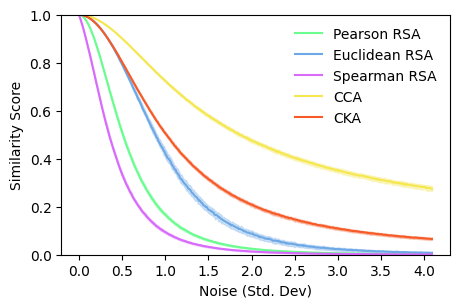

In [15]:
noisePath = "../outputs/masterOutput/noiseSims2021.csv"
ccaPath = "../outputs/masterOutput/pwccaNoise.csv"
noiseData = pd.read_csv(noisePath, index_col=0)
tmp = pd.read_csv(ccaPath, index_col=0)
tmp.index = noiseData.index
noiseData["cca"] = tmp["pwcca"]
noiseData[rsaMetrics] = noiseData[rsaMetrics] ** 2

noiseMean = noiseData.groupby(["Noise"])[funNames].agg(np.mean)
noiseCI = noiseData.groupby(["Noise"])[funNames].agg(
    lambda x: (np.mean(x) - pg.mad(x), np.mean(x) + pg.mad(x))
)
noiseData.head()

# Get unique noise
noise = noiseData["Noise"].unique()
# Sort noise
noise = np.sort(noise)

fig = plt.figure(figsize=(plotWidth, plotHeight))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.8])
ax.plot(noiseMean["peaRsa"], color=peaRsaColor, label="Pearson RSA")
ax.fill_between(
    noise,
    [x[0] for x in noiseCI["peaRsa"]],
    [x[1] for x in noiseCI["peaRsa"]],
    zorder=-1,
    alpha=0.3,
    color=peaRsaColor,
)
ax.plot(noiseMean["eucRsa"], color=eucRsaColor, label="Euclidean RSA")
ax.fill_between(
    noise,
    [x[0] for x in noiseCI["eucRsa"]],
    [x[1] for x in noiseCI["eucRsa"]],
    zorder=-1,
    alpha=0.3,
    color=eucRsaColor,
)
ax.plot(noiseMean["speRsa"], color=speRsaColor, label="Spearman RSA")
ax.fill_between(
    noise,
    [x[0] for x in noiseCI["speRsa"]],
    [x[1] for x in noiseCI["speRsa"]],
    zorder=-1,
    alpha=0.3,
    color=speRsaColor,
)
ax.plot(noiseMean["cca"], color=ccaColor, label="CCA")
ax.fill_between(
    noise,
    [x[0] for x in noiseCI["cca"]],
    [x[1] for x in noiseCI["cca"]],
    zorder=-1,
    alpha=0.3,
    color=ccaColor,
)
ax.plot(noiseMean["cka"], color=ckaColor, label="CKA")
ax.fill_between(
    noise,
    [x[0] for x in noiseCI["cka"]],
    [x[1] for x in noiseCI["cka"]],
    zorder=-1,
    alpha=0.3,
    color=ckaColor,
)
ax.legend(frameon=False)
ax.set_xlabel("Noise (Std. Dev)")
ax.set_ylabel("Similarity Score")
ax.set_ylim((0, 1))

# Tight layout
fig.tight_layout()

# Save image
fig.show()
fig.savefig("../outputs/masterOutput/manuscriptFigures/noiseSims.png")

In [16]:
print(f"CCA mean = {noiseData.loc[noiseData['Noise'] == 4.0, 'cca'].mean()}")
print(f"CCA CI = {bootstrapCI(noiseData.loc[noiseData['Noise'] == 4.0, 'cca'])}")

print(f"CKA mean = {noiseData.loc[noiseData['Noise'] == 4.0, 'cka'].mean()}")
print(f"CKA CI = {bootstrapCI(noiseData.loc[noiseData['Noise'] == 4.0, 'cka'])}")

CCA mean = 0.2823547141386404
CCA CI = (0.28047926732815553, 0.28411976322790966)
CKA mean = 0.0684208997594608
CKA CI = (0.06749544521566975, 0.06941932501019031)


/tmp/ipykernel_2855135/2067233836.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


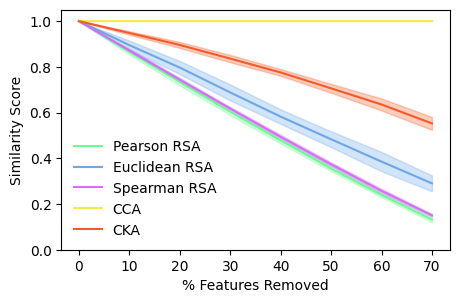

In [17]:
ablatePath = "../outputs/masterOutput/ablateSims.csv"
pwccaPath = "../outputs/masterOutput/pwccaAblate.csv"
ablateData = pd.read_csv(ablatePath, index_col=0)
ablateData["Neurons"] = np.abs(ablateData["Neurons"] - 10)
tmp = pd.read_csv(pwccaPath, index_col=0)
tmp["Neurons"] = np.abs(tmp["Neurons"] - 10)
tmp.index = ablateData.index
ablateData["cca"] = tmp["pwcca"]

ablateData[rsaMetrics] = ablateData[rsaMetrics] ** 2
ablateMean = ablateData.groupby(["Neurons"])[funNames].agg(np.mean)
ablateCI = ablateData.groupby(["Neurons"])[funNames].agg(
    lambda x: (np.mean(x) - pg.mad(x), np.mean(x) + pg.mad(x))
)
ablateMean = ablateMean.set_index(ablateMean.index * 10)
ablateCI = ablateCI.set_index(ablateCI.index * 10)

fig = plt.figure(figsize=(plotWidth, plotHeight))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.8])
ax.plot(ablateMean["peaRsa"], color=peaRsaColor, label="Pearson RSA")
ax.fill_between(
    range(0, 80, 10),
    [x[0] for x in ablateCI["peaRsa"]],
    [x[1] for x in ablateCI["peaRsa"]],
    zorder=-1,
    alpha=0.3,
    color=peaRsaColor,
)
ax.plot(ablateMean["eucRsa"], color=eucRsaColor, label="Euclidean RSA")
ax.fill_between(
    range(0, 80, 10),
    [x[0] for x in ablateCI["eucRsa"]],
    [x[1] for x in ablateCI["eucRsa"]],
    zorder=-1,
    alpha=0.3,
    color=eucRsaColor,
)
ax.plot(ablateMean["speRsa"], color=speRsaColor, label="Spearman RSA")
ax.fill_between(
    range(0, 80, 10),
    [x[0] for x in ablateCI["speRsa"]],
    [x[1] for x in ablateCI["speRsa"]],
    zorder=-1,
    alpha=0.3,
    color=speRsaColor,
)
ax.plot(ablateMean["cca"], color=ccaColor, label="CCA")
ax.fill_between(
    range(0, 80, 10),
    [x[0] for x in ablateCI["cca"]],
    [x[1] for x in ablateCI["cca"]],
    zorder=-1,
    alpha=0.3,
    color=ccaColor,
)
ax.plot(ablateMean["cka"], color=ckaColor, label="CKA")
ax.fill_between(
    range(0, 80, 10),
    [x[0] for x in ablateCI["cka"]],
    [x[1] for x in ablateCI["cka"]],
    zorder=-1,
    alpha=0.3,
    color=ckaColor,
)

ax.legend(frameon=False)
ax.set_xlabel("% Features Removed")
ax.set_ylabel("Similarity Score")
ax.set_ylim(0, 1.05)

# Tight layout
fig.tight_layout()

fig.show()

fig.savefig("../outputs/masterOutput/manuscriptFigures/ablateSims.png")

/data/venv/research2/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/tmp/ipykernel_2855135/2253472722.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_xlabels)
/tmp/ipykernel_2855135/2253472722.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


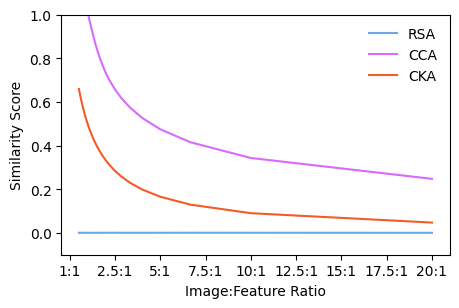

In [18]:
ratioPath = "../outputs/masterOutput/ratioSims.csv"
pwccaPath = "../outputs/masterOutput/pwccaSizeRatio.csv"
ratioSims = pd.read_csv(ratioPath)
tmp = pd.read_csv(pwccaPath)
tmp.index = ratioSims.index
ratioSims["cca"] = tmp["pwcca"]
ratioSims[rsaMetrics] = ratioSims[rsaMetrics] ** 2
ratioSims["ratio"] = ratioSims["sample"] / ratioSims["features"]

ratios = ratioSims["ratio"].unique()
ratioData = pd.DataFrame(
    columns=list(ratioSims.columns[0:3]) + ["ratio"], index=range(len(ratios))
)
for i, ratio in enumerate(ratios):
    ratioData.loc[i] = list(
        ratioSims.loc[ratioSims["ratio"] == ratio, ratioSims.columns[0:3]].mean("index")
    ) + [ratio]

ratioMeans = ratioSims.groupby(["ratio"])[funNames].agg(np.mean)
ratioCI = ratioSims.groupby(["ratio"])[funNames].agg(
    lambda x: (np.mean(x) - pg.mad(x), np.mean(x) + pg.mad(x))
)

fig = plt.figure(figsize=(plotWidth, plotHeight))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.8])
ax.plot(ratioMeans["eucRsa"], label="RSA", color=eucRsaColor)
ax.plot(ratioMeans["cca"], label="CCA", color=speRsaColor)
ax.plot(ratioMeans["cka"], label="CKA", color=ckaColor)
ax.set_xlabel("Image:Feature Ratio")
ax.set_ylabel("Similarity Score")
ax.legend(frameon=False)

# Get current tick labels
xlabels = ax.get_xticklabels()
# Add :1 to each label
new_xlabels = [x.get_text() for x in xlabels]
new_xlabels = [x.rstrip("0").rstrip(".") + ":1" for x in new_xlabels]

# Change 0:1 to 1:1
new_xlabels[1] = "1:1"

# Set tick labels
ax.set_xticklabels(new_xlabels)


ax.set_ylim(-0.1, 1)
# Tight layout
fig.tight_layout()

fig.show()

fig.savefig("../outputs/masterOutput/manuscriptFigures/ratioSims.png")

In [19]:
new_xlabels

['−2.5:1',
 '1:1',
 '2.5:1',
 '5:1',
 '7.5:1',
 '10:1',
 '12.5:1',
 '15:1',
 '17.5:1',
 '20:1',
 '22.5:1']

In [20]:
print(f"CKA at 20:1 ratio: {ratioSims.loc[ratioSims['ratio'] == 20.0, 'cka'].mean()}")

CKA at 20:1 ratio: 0.047396731670448035


In [21]:
sanityPath = "../outputs/masterOutput/vggSanity.csv"
bigSanity = pd.read_csv(sanityPath, index_col=0)
bigSanity[rsaMetrics] = bigSanity[rsaMetrics] ** 2

permutePath = "../outputs/masterOutput/vggPermuteSims.csv"
bigPermute = pd.read_csv(permutePath, index_col=0)
bigPermute[rsaMetrics] = bigPermute[rsaMetrics] ** 2

print(
    f"VGG16" f"Sanity Test",
    f"Pearson RSA -- mean {np.mean(bigSanity['peaRsa'])}",
    f"SD {pg.mad(bigSanity['peaRsa'])}",
    f"Eucliean RSA -- mean {np.mean(bigSanity['eucRsa'])}",
    f"SD {pg.mad(bigSanity['eucRsa'])}",
    f"Spearman RSA -- mean {np.mean(bigSanity['speRsa'])}",
    f"SD {pg.mad(bigSanity['speRsa'])}",
    f"CCA -- mean {np.mean(bigSanity['cca'])}",
    f"SD {pg.mad(bigSanity['cca'])}",
    f"CKA -- mean {np.mean(bigSanity['cka'])}",
    f"SD {pg.mad(bigSanity['cka'])}",
    "",
    f"Random Test",
    f"Pearson RSA -- mean {np.mean(bigPermute.loc[bigPermute['analysis'] == 'random', 'peaRsa'])}",
    f"SD {pg.mad(bigPermute.loc[bigPermute['analysis'] == 'random', 'peaRsa'])}",
    f"Euclidean RSA -- mean {np.mean(bigPermute.loc[bigPermute['analysis'] == 'random', 'eucRsa'])}",
    f"SD {pg.mad(bigPermute.loc[bigPermute['analysis'] == 'random', 'eucRsa'])}",
    f"Spearman RSA -- mean {np.mean(bigPermute.loc[bigPermute['analysis'] == 'random', 'speRsa'])}",
    f"SD {pg.mad(bigPermute.loc[bigPermute['analysis'] == 'random', 'speRsa'])}",
    f"CCA -- mean {np.mean(bigPermute.loc[bigPermute['analysis'] == 'random', 'cca'])}",
    f"SD {pg.mad(bigPermute.loc[bigPermute['analysis'] == 'random', 'cca'])}",
    f"CKA -- mean {np.mean(bigPermute.loc[bigPermute['analysis'] == 'random', 'cka'])}",
    f"SD {pg.mad(bigPermute.loc[bigPermute['analysis'] == 'random', 'cka'])}",
    sep="\n",
)

VGG16Sanity Test
Pearson RSA -- mean 0.9999999523163006
SD 2.6510994363258917e-07
Eucliean RSA -- mean 1.0000000476837207
SD 8.836997594360188e-08
Spearman RSA -- mean 0.0024765418882153048
SD 0.0016599555290608403
CCA -- mean 0.999999999712131
SD 1.2820842920580202e-12
CKA -- mean 1.0001975676839336
SD 0.000545022001498981

Random Test
Pearson RSA -- mean 2.5283773202262058e-08
SD 1.1517371220960263e-08
Euclidean RSA -- mean 0.02338785202753311
SD 0.0027960651681300528
Spearman RSA -- mean 2.1015101831837906e-08
SD 1.1987005317976425e-08
CCA -- mean 0.2632779257665556
SD 0.0021178568989853046
CKA -- mean 0.08422102021305608
SD 0.0014871050227176271


In [22]:
sanityPath = "../outputs/masterOutput/resnetSanity.csv"
bigSanity = pd.read_csv(sanityPath, index_col=0)
bigSanity[rsaMetrics] = bigSanity[rsaMetrics] ** 2

permutePath = "../outputs/masterOutput/resnetPermuteSims.csv"
bigPermute = pd.read_csv(permutePath, index_col=0)
bigPermute[rsaMetrics] = bigPermute[rsaMetrics] ** 2

print(
    f"Resnet" f"Sanity Test",
    f"Pearson RSA -- mean {np.mean(bigSanity['peaRsa'])}",
    f"SD {pg.mad(bigSanity['peaRsa'])}",
    f"Eucliean RSA -- mean {np.mean(bigSanity['eucRsa'])}",
    f"SD {pg.mad(bigSanity['eucRsa'])}",
    f"Spearman RSA -- mean {np.mean(bigSanity['speRsa'])}",
    f"SD {pg.mad(bigSanity['speRsa'])}",
    f"CCA -- mean {np.mean(bigSanity['cca'])}",
    f"SD {pg.mad(bigSanity['cca'])}",
    f"CKA -- mean {np.mean(bigSanity['cka'])}",
    f"SD {pg.mad(bigSanity['cka'])}",
    "",
    f"Random Test",
    f"Pearson RSA -- mean {np.mean(bigPermute.loc[bigPermute['analysis'] == 'random', 'peaRsa'])}",
    f"SD {pg.mad(bigPermute.loc[bigPermute['analysis'] == 'random', 'peaRsa'])}",
    f"Euclidean RSA -- mean {np.mean(bigPermute.loc[bigPermute['analysis'] == 'random', 'eucRsa'])}",
    f"SD {pg.mad(bigPermute.loc[bigPermute['analysis'] == 'random', 'eucRsa'])}",
    f"Spearman RSA -- mean {np.mean(bigPermute.loc[bigPermute['analysis'] == 'random', 'speRsa'])}",
    f"SD {pg.mad(bigPermute.loc[bigPermute['analysis'] == 'random', 'speRsa'])}",
    f"CCA -- mean {np.mean(bigPermute.loc[bigPermute['analysis'] == 'random', 'cca'])}",
    f"SD {pg.mad(bigPermute.loc[bigPermute['analysis'] == 'random', 'cca'])}",
    f"CKA -- mean {np.mean(bigPermute.loc[bigPermute['analysis'] == 'random', 'cka'])}",
    f"SD {pg.mad(bigPermute.loc[bigPermute['analysis'] == 'random', 'cka'])}",
    "",
    sep="\n",
)

ResnetSanity Test
Pearson RSA -- mean 0.9999999761581606
SD 3.534798932398852e-07
Eucliean RSA -- mean 0.9999999880790735
SD 0.0
Spearman RSA -- mean 0.9999999523162927
SD 3.534798932398852e-07
CCA -- mean 0.9999999996632394
SD 8.496339189280379e-12
CKA -- mean 1.0000012421935698
SD 1.8083110522433064e-06

Random Test
Pearson RSA -- mean 2.4890979599082267e-08
SD 1.291573321828024e-08
Euclidean RSA -- mean 0.029892734031150905
SD 0.002685616545556786
Spearman RSA -- mean 1.70538660401885e-08
SD 9.69245691803389e-09
CCA -- mean 0.26333746596710217
SD 0.0018133664708455356
CKA -- mean 0.08400927388037265
SD 0.0012039038569118176



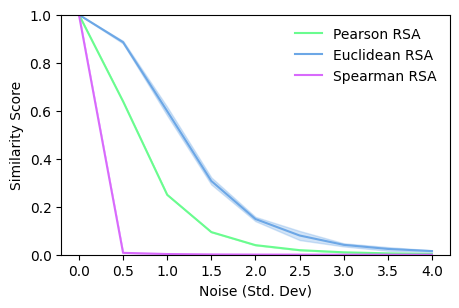

In [23]:
noisePath = "../outputs/masterOutput/vggNoise.csv"
noiseData = pd.read_csv(noisePath, index_col=0)
noiseData[rsaMetrics] = noiseData[rsaMetrics] ** 2

noiseMean = noiseData.groupby(["Noise"])[funNames].agg(np.mean)
noiseCI = noiseData.groupby(["Noise"])[funNames].agg(
    lambda x: (np.mean(x) - pg.mad(x), np.mean(x) + pg.mad(x))
)
noiseData.head()

# Get unique noise
noise = noiseData["Noise"].unique()
# Sort noise
noise = np.sort(noise)

fig = plt.figure(figsize=(plotWidth, plotHeight))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.8])
ax.plot(noiseMean["peaRsa"], color=peaRsaColor, label="Pearson RSA")
ax.fill_between(
    noise,
    [x[0] for x in noiseCI["peaRsa"]],
    [x[1] for x in noiseCI["peaRsa"]],
    zorder=-1,
    alpha=0.3,
    color=peaRsaColor,
)
ax.plot(noiseMean["eucRsa"], color=eucRsaColor, label="Euclidean RSA")
ax.fill_between(
    noise,
    [x[0] for x in noiseCI["eucRsa"]],
    [x[1] for x in noiseCI["eucRsa"]],
    zorder=-1,
    alpha=0.3,
    color=eucRsaColor,
)
ax.plot(noiseMean["speRsa"], color=speRsaColor, label="Spearman RSA")
ax.fill_between(
    noise,
    [x[0] for x in noiseCI["speRsa"]],
    [x[1] for x in noiseCI["speRsa"]],
    zorder=-1,
    alpha=0.3,
    color=speRsaColor,
)

ax.legend(frameon=False, loc="upper right")
ax.set_xlabel("Noise (Std. Dev)")
ax.set_ylabel("Similarity Score")
ax.set_ylim((0, 1))

# Save image
fig.savefig("../outputs/masterOutput/manuscriptFigures/vggNoiseSims.png")
fig.show()

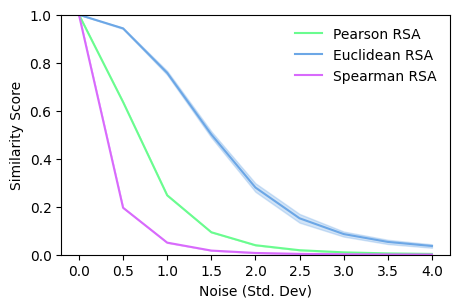

In [24]:
noisePath = "../outputs/masterOutput/resnetNoise.csv"
noiseData = pd.read_csv(noisePath, index_col=0)
noiseData[rsaMetrics] = noiseData[rsaMetrics] ** 2

noiseMean = noiseData.groupby(["Noise"])[funNames].agg(np.mean)
noiseCI = noiseData.groupby(["Noise"])[funNames].agg(
    lambda x: (np.mean(x) - pg.mad(x), np.mean(x) + pg.mad(x))
)
noiseData.head()

# Get unique noise
noise = noiseData["Noise"].unique()
# Sort noise
noise = np.sort(noise)

fig = plt.figure(figsize=(plotWidth, plotHeight))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.8])
ax.plot(noiseMean["peaRsa"], color=peaRsaColor, label="Pearson RSA")
ax.fill_between(
    noise,
    [x[0] for x in noiseCI["peaRsa"]],
    [x[1] for x in noiseCI["peaRsa"]],
    zorder=-1,
    alpha=0.3,
    color=peaRsaColor,
)
ax.plot(noiseMean["eucRsa"], color=eucRsaColor, label="Euclidean RSA")
ax.fill_between(
    noise,
    [x[0] for x in noiseCI["eucRsa"]],
    [x[1] for x in noiseCI["eucRsa"]],
    zorder=-1,
    alpha=0.3,
    color=eucRsaColor,
)
ax.plot(noiseMean["speRsa"], color=speRsaColor, label="Spearman RSA")
ax.fill_between(
    noise,
    [x[0] for x in noiseCI["speRsa"]],
    [x[1] for x in noiseCI["speRsa"]],
    zorder=-1,
    alpha=0.3,
    color=speRsaColor,
)

ax.legend(frameon=False, loc="upper right")
ax.set_xlabel("Noise (Std. Dev)")
ax.set_ylabel("Similarity Score")
ax.set_ylim((0, 1))

# Save image
fig.savefig("../outputs/masterOutput/manuscriptFigures/resnetNoiseSims.png")
fig.show()

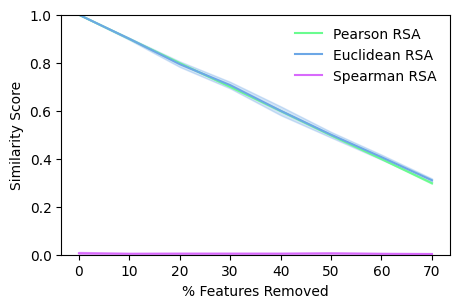

In [25]:
ablatePath = "../outputs/masterOutput/vggAblate.csv"
ablateData = pd.read_csv(ablatePath, index_col=0)
ablateData["Neurons"] = np.abs(ablateData["Neurons"] - 4096) / 4096 * 100

ablateData[rsaMetrics] = ablateData[rsaMetrics] ** 2
ablateMean = ablateData.groupby(["Neurons"])[funNames].agg(np.mean)
ablateCI = ablateData.groupby(["Neurons"])[funNames].agg(
    lambda x: (np.mean(x) - pg.mad(x), np.mean(x) + pg.mad(x))
)

fig = plt.figure(figsize=(plotWidth, plotHeight))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.8])
ax.plot(ablateMean["peaRsa"], color=peaRsaColor, label="Pearson RSA")
ax.fill_between(
    np.unique(ablateData["Neurons"]),
    [x[0] for x in ablateCI["peaRsa"]],
    [x[1] for x in ablateCI["peaRsa"]],
    zorder=-1,
    alpha=0.3,
    color=peaRsaColor,
)
ax.plot(ablateMean["eucRsa"], color=eucRsaColor, label="Euclidean RSA")
ax.fill_between(
    np.unique(ablateData["Neurons"]),
    [x[0] for x in ablateCI["eucRsa"]],
    [x[1] for x in ablateCI["eucRsa"]],
    zorder=-1,
    alpha=0.3,
    color=eucRsaColor,
)
ax.plot(ablateMean["speRsa"], color=speRsaColor, label="Spearman RSA")
ax.fill_between(
    np.unique(ablateData["Neurons"]),
    [x[0] for x in ablateCI["speRsa"]],
    [x[1] for x in ablateCI["speRsa"]],
    zorder=-1,
    alpha=0.3,
    color=speRsaColor,
)

ax.legend(frameon=False)
ax.set_xlabel("% Features Removed")
ax.set_ylabel("Similarity Score")
ax.set_ylim(0, 1)

# Save image
fig.savefig("../outputs/masterOutput/manuscriptFigures/vggAblateSims.png")
fig.show()

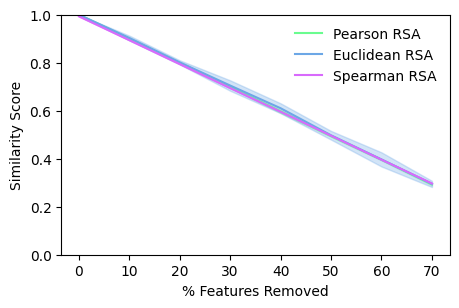

In [26]:
ablatePath = "../outputs/masterOutput/resnetAblate.csv"
ablateData = pd.read_csv(ablatePath, index_col=0)
ablateData["Neurons"] = np.abs(ablateData["Neurons"] - 2048) / 2048 * 100

ablateData[rsaMetrics] = ablateData[rsaMetrics] ** 2
ablateMean = ablateData.groupby(["Neurons"])[funNames].agg(np.mean)
ablateCI = ablateData.groupby(["Neurons"])[funNames].agg(
    lambda x: (np.mean(x) - pg.mad(x), np.mean(x) + pg.mad(x))
)

fig = plt.figure(figsize=(plotWidth, plotHeight))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.8])
ax.plot(ablateMean["peaRsa"], color=peaRsaColor, label="Pearson RSA")
ax.fill_between(
    np.unique(ablateData["Neurons"]),
    [x[0] for x in ablateCI["peaRsa"]],
    [x[1] for x in ablateCI["peaRsa"]],
    zorder=-1,
    alpha=0.3,
    color=peaRsaColor,
)
ax.plot(ablateMean["eucRsa"], color=eucRsaColor, label="Euclidean RSA")
ax.fill_between(
    np.unique(ablateData["Neurons"]),
    [x[0] for x in ablateCI["eucRsa"]],
    [x[1] for x in ablateCI["eucRsa"]],
    zorder=-1,
    alpha=0.3,
    color=eucRsaColor,
)
ax.plot(ablateMean["speRsa"], color=speRsaColor, label="Spearman RSA")
ax.fill_between(
    np.unique(ablateData["Neurons"]),
    [x[0] for x in ablateCI["speRsa"]],
    [x[1] for x in ablateCI["speRsa"]],
    zorder=-1,
    alpha=0.3,
    color=speRsaColor,
)

ax.legend(frameon=False)
ax.set_xlabel("% Features Removed")
ax.set_ylabel("Similarity Score")
ax.set_ylim(0, 1)

# Save image
fig.savefig("../outputs/masterOutput/manuscriptFigures/resnetAblateSims.png")
fig.show()

In [27]:
trainingTraj_seed = pd.read_csv("../outputs/masterOutput/trainingTraj.csv")
weightAcc = trainingTraj_seed.groupby("weightSeed")["valAcc"].agg(np.mean)
shuffleAcc = trainingTraj_seed.groupby("shuffleSeed")["valAcc"].agg(np.mean)

# t-test on accuracy
print(st.ttest_ind(weightAcc, shuffleAcc))

finalAcc_seed = trainingTraj_seed["valAcc"].loc[trainingTraj_seed["epoch"] == 349]
print("Accuracy Mean - Seed: " + str(np.mean(finalAcc_seed)))
print("Accuracy SD - Seed: " + str(pg.mad(finalAcc_seed)))
print(f"Accuracy Range - Seed: {np.min(finalAcc_seed)} - {np.max(finalAcc_seed)}")
print()
trainingMean_seed = trainingTraj_seed.groupby("epoch")["valAcc"].agg(np.mean)
trainingCI_seed = trainingTraj_seed.groupby("epoch")["valAcc"].agg(pg.mad)

trainingTraj_item_max3 = pd.read_csv(
    "../outputs/masterOutput/trainingTraj_itemDiff_max3.csv"
)
finalAcc_item_max3 = trainingTraj_item_max3["valAcc"].loc[
    trainingTraj_item_max3["epoch"] == 349
]
print("Accuracy Mean - item max 3: " + str(np.mean(finalAcc_item_max3)))
print("Accuracy SD - item max 3: " + str(pg.mad(finalAcc_item_max3)))
print(
    f"Accuracy Range - item max 3: {np.min(finalAcc_item_max3)} - {np.max(finalAcc_item_max3)}"
)
print()

trainingMean_item_max3 = trainingTraj_item_max3.groupby("epoch")["valAcc"].agg(np.mean)
trainingCI_item_max3 = trainingTraj_item_max3.groupby("epoch")["valAcc"].agg(pg.mad)

trainingTraj_item_max10 = pd.read_csv(
    "../outputs/masterOutput/trainingTraj_itemDiff_max10.csv"
)
finalAcc_item_max10 = trainingTraj_item_max10["valAcc"].loc[
    trainingTraj_item_max10["epoch"] == 349
]
print("Accuracy Mean - item max 10: " + str(np.mean(finalAcc_item_max10)))
print("Accuracy SD - item max 10: " + str(pg.mad(finalAcc_item_max10)))
print(
    f"Accuracy Range - item max 10: {np.min(finalAcc_item_max10)} - {np.max(finalAcc_item_max10)}"
)
print()

trainingMean_item_max10 = trainingTraj_item_max10.groupby("epoch")["valAcc"].agg(
    np.mean
)
trainingCI_item_max10 = trainingTraj_item_max10.groupby("epoch")["valAcc"].agg(pg.mad)

trainingTraj_item_max100 = pd.read_csv(
    "../outputs/masterOutput/trainingTraj_itemDiff_max100.csv"
)
finalAcc_item_max100 = trainingTraj_item_max100["valAcc"].loc[
    trainingTraj_item_max100["epoch"] == 349
]
print("Accuracy Mean - item max 100: " + str(np.mean(finalAcc_item_max100)))
print("Accuracy SD - item max 100: " + str(pg.mad(finalAcc_item_max100)))
print(
    f"Accuracy Range - item max 100: {np.min(finalAcc_item_max100)} - {np.max(finalAcc_item_max100)}"
)
print()

trainingMean_item_max100 = trainingTraj_item_max100.groupby("epoch")["valAcc"].agg(
    np.mean
)
trainingCI_item_max100 = trainingTraj_item_max100.groupby("epoch")["valAcc"].agg(pg.mad)

trainingTraj_cat_max3 = pd.read_csv(
    "../outputs/masterOutput/trainingTraj_catDiff_max1-3.csv"
)
finalAcc_cat_max3 = trainingTraj_cat_max3["valAcc"].loc[
    trainingTraj_cat_max3["epoch"] == 349
]
print("Accuracy Mean - cat max 3: " + str(np.mean(finalAcc_cat_max3)))
print("Accuracy SD - cat max 3: " + str(pg.mad(finalAcc_cat_max3)))
print(
    f"Accuracy Range - cat max 3: {np.min(finalAcc_cat_max3)} - {np.max(finalAcc_cat_max3)}"
)
print()

trainingMean_cat_max3 = trainingTraj_cat_max3.groupby("epoch")["valAcc"].agg(np.mean)
trainingCI_cat_max3 = trainingTraj_cat_max3.groupby("epoch")["valAcc"].agg(pg.mad)

trainingTraj_cat_max10 = pd.read_csv(
    "../outputs/masterOutput/trainingTraj_catDiff_max1-10.csv"
)
finalAcc_cat_max10 = trainingTraj_cat_max10["valAcc"].loc[
    trainingTraj_cat_max10["epoch"] == 349
]
print("Accuracy Mean - cat max 10: " + str(np.mean(finalAcc_cat_max10)))
print("Accuracy SD - cat max 10: " + str(pg.mad(finalAcc_cat_max10)))
print(
    f"Accuracy Range - cat max 10: {np.min(finalAcc_cat_max10)} - {np.max(finalAcc_cat_max10)}"
)
print()

trainingMean_cat_max10 = trainingTraj_cat_max10.groupby("epoch")["valAcc"].agg(np.mean)
trainingCI_cat_max10 = trainingTraj_cat_max10.groupby("epoch")["valAcc"].agg(pg.mad)

trainingTraj_cat_max100 = pd.read_csv(
    "../outputs/masterOutput/trainingTraj_catDiff_max1-100.csv"
)
finalAcc_cat_max100 = trainingTraj_cat_max100["valAcc"].loc[
    trainingTraj_cat_max100["epoch"] == 349
]
print("Accuracy Mean - cat max 100: " + str(np.mean(finalAcc_cat_max100)))
print("Accuracy SD - cat max 100: " + str(pg.mad(finalAcc_cat_max100)))
print(
    f"Accuracy Range - cat max 100: {np.min(finalAcc_cat_max100)} - {np.max(finalAcc_cat_max100)}"
)
print()

trainingMean_cat_max100 = trainingTraj_cat_max100.groupby("epoch")["valAcc"].agg(
    np.mean
)
trainingCI_cat_max100 = trainingTraj_cat_max100.groupby("epoch")["valAcc"].agg(pg.mad)

Ttest_indResult(statistic=0.0, pvalue=1.0)
Accuracy Mean - Seed: 0.908897
Accuracy SD - Seed: 0.0020015129949826713
Accuracy Range - Seed: 0.9011 - 0.9143

Accuracy Mean - item max 3: 0.88193
Accuracy SD - item max 3: 0.0008895613311034277
Accuracy Range - item max 3: 0.878 - 0.8837

Accuracy Mean - item max 10: 0.87995
Accuracy SD - item max 10: 0.0017791226622067733
Accuracy Range - item max 10: 0.8771 - 0.8825

Accuracy Mean - item max 100: 0.879282
Accuracy SD - item max 100: 0.0031875947697870225
Accuracy Range - item max 100: 0.8732 - 0.8851

Accuracy Mean - cat max 3: 0.8777839999999999
Accuracy SD - cat max 3: 0.0031875947697870225
Accuracy Range - cat max 3: 0.8692 - 0.8857

Accuracy Mean - cat max 10: 0.8666620000000002
Accuracy SD - cat max 10: 0.01000756497491278
Accuracy Range - cat max 10: 0.8451 - 0.8865

Accuracy Mean - cat max 100: 0.8535260000000001
Accuracy SD - cat max 100: 0.016901665290963812
Accuracy Range - cat max 100: 0.8059 - 0.8836



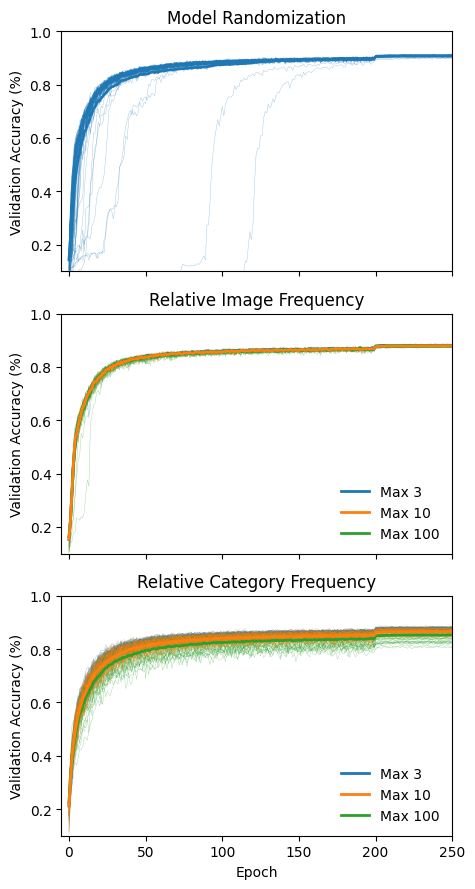

In [28]:
# part2Colors = ["#4E83E6", "#E6644E", "#B84EE6"]
part2Colors = ["C0", "C1", "C2"]


def plotTraj(
    ax,
    trainingMean,
    trainingTraj,
    color="k",
    label="",
    title="",
    xlabel="",
    ylabel="",
    legend=False,
    zorder=0,
):
    # Plot mean and CI
    ax.plot(
        range(len(trainingMean)),
        trainingMean,
        color=color,
        zorder=zorder,
        linewidth=2,
        label=label,
    )

    # Get unique logs
    logs = trainingTraj["log"].unique()
    # Loop through logs and plot validation accuracy
    for i, log in enumerate(logs):
        logAcc = trainingTraj.loc[trainingTraj["log"] == log, "valAcc"]
        ax.plot(
            range(len(logAcc)),
            logAcc,
            color=color,
            alpha=0.5,
            zorder=zorder - 1,
            linewidth=0.25,
        )

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim((-5, 250))
    ax.set_ylim((0.1, 1))

    if legend:
        ax.legend(loc="lower right", frameon=False)


fig, axs = plt.subplots(3, 1, figsize=(plotWidth, plotHeight * 3), sharex=True)

plotTraj(
    ax=axs[0],
    trainingMean=trainingMean_seed,
    trainingTraj=trainingTraj_seed,
    color=part2Colors[0],
    label="",
    xlabel="",
    ylabel="Validation Accuracy (%)",
    zorder=2,
    legend=False,
    title="Model Randomization",
)


plotTraj(
    ax=axs[1],
    trainingMean=trainingMean_item_max3,
    trainingTraj=trainingTraj_item_max3,
    color=part2Colors[0],
    label="Max 3",
    xlabel="",
    ylabel="",
    zorder=1,
)
plotTraj(
    ax=axs[1],
    trainingMean=trainingMean_item_max10,
    trainingTraj=trainingTraj_item_max10,
    color=part2Colors[1],
    label="Max 10",
    xlabel="",
    ylabel="",
    zorder=3,
)
plotTraj(
    ax=axs[1],
    trainingMean=trainingMean_item_max100,
    trainingTraj=trainingTraj_item_max100,
    color=part2Colors[2],
    label="Max 100",
    xlabel="",
    ylabel="Validation Accuracy (%)",
    zorder=2,
    title="Relative Image Frequency",
    legend=True,
)


plotTraj(
    ax=axs[2],
    trainingMean=trainingMean_cat_max3,
    trainingTraj=trainingTraj_cat_max3,
    color=part2Colors[0],
    label="Max 3",
    xlabel="",
    ylabel="",
    zorder=1,
)
plotTraj(
    ax=axs[2],
    trainingMean=trainingMean_cat_max10,
    trainingTraj=trainingTraj_cat_max10,
    color=part2Colors[1],
    label="Max 10",
    xlabel="",
    ylabel="",
    zorder=3,
)
plotTraj(
    ax=axs[2],
    trainingMean=trainingMean_cat_max100,
    trainingTraj=trainingTraj_cat_max100,
    color=part2Colors[2],
    label="Max 100",
    xlabel="Epoch",
    ylabel="Validation Accuracy (%)",
    zorder=2,
    title="Relative Category Frequency",
    legend=True,
)

# fig.subplots_adjust(hspace=0.1)

# Tight layout
fig.tight_layout()
fig.show()

# Save
fig.savefig("../outputs/masterOutput/manuscriptFigures/trainingTajectory.png")

In [29]:
seedDiffSims = pd.read_csv(
    "../outputs/masterOutput/similarities/seedDiff_allLayers.csv"
)
seedDiffSims.eucRsa = seedDiffSims.eucRsa**2

weight1 = np.zeros_like(seedDiffSims.eucRsa)
weight2 = np.zeros_like(seedDiffSims.eucRsa)
shuffle1 = np.zeros_like(seedDiffSims.eucRsa)
shuffle2 = np.zeros_like(seedDiffSims.eucRsa)
for row in seedDiffSims.iterrows():
    weight, shuffle = row[1].model1.split("s")
    weight1[row[0]] = int(weight[1])
    shuffle1[row[0]] = int(shuffle)

    weight, shuffle = row[1].model2.split("s")
    weight2[row[0]] = int(weight[1])
    shuffle2[row[0]] = int(shuffle)

seedDiffSims["weight1"] = weight1.astype(int)
seedDiffSims["weight2"] = weight2.astype(int)
seedDiffSims["shuffle1"] = shuffle1.astype(int)
seedDiffSims["shuffle2"] = shuffle2.astype(int)

seedDiffSims.head()

,model1,model2,eucRsa,cka,layer,weight1,weight2,shuffle1,shuffle2
0,w1s0,w0s0,0.842940,0.872618,5,1,0,0,0
1,w2s0,w0s0,0.930062,0.926449,5,2,0,0,0
2,w2s0,w1s0,0.837260,0.876816,5,2,1,0,0
3,w3s0,w0s0,0.900026,0.913239,5,3,0,0,0
4,w3s0,w1s0,0.821347,0.878421,5,3,1,0,0


In [30]:
# Loop through weight/shuffle seeds and layers
weights = seedDiffSims.weight1.unique()
weights.sort()
shuffles = seedDiffSims.shuffle1.unique()
shuffles.sort()
layers = seedDiffSims.layer.unique()
layers.sort()
shuffleDiffs = np.zeros((len(weights), math.comb(len(shuffles), 2), len(layers)))
weightDiffs = np.zeros((len(weights), math.comb(len(weights), 2), len(layers)))
for weightSeed in weights:
    # Find rows with matching weight seeds for both models
    weightRows = seedDiffSims.loc[
        (seedDiffSims["weight1"] == weightSeed)
        & (seedDiffSims["weight2"] == weightSeed)
    ]

    for layer in layers:
        layerRows = weightRows.loc[weightRows["layer"] == layer]
        layerRows = layerRows.sort_values(["shuffle1", "shuffle2"])

        # Save eucRsa scores
        shuffleDiffs[weightSeed, :, layer] = layerRows.eucRsa.values

for shuffleSeed in shuffles:
    # Find rows with matching weight seeds for both models
    shuffleRows = seedDiffSims.loc[
        (seedDiffSims["shuffle1"] == shuffleSeed)
        & (seedDiffSims["shuffle2"] == shuffleSeed)
    ]

    for layer in layers:
        layerRows = shuffleRows.loc[shuffleRows["layer"] == layer]
        layerRows = layerRows.sort_values(["weight1", "weight2"])

        # Save eucRsa scores
        weightDiffs[shuffleSeed, :, layer] = layerRows.eucRsa.values


shuffleDiffMeans = np.mean(shuffleDiffs, axis=(0, 1))
weightDiffMeans = np.mean(weightDiffs, axis=(0, 1))
shuffleDiffStd = pg.mad(shuffleDiffs, axis=(0, 1))
weightDiffStd = pg.mad(weightDiffs, axis=(0, 1))

# Only use layers first 8 layers
layers = [0, 1, 2, 3, 4, 5, 6, 7]
shuffleDiffMeans = shuffleDiffMeans[layers]
weightDiffMeans = weightDiffMeans[layers]
shuffleDiffStd = shuffleDiffStd[layers]
weightDiffStd = weightDiffStd[layers]

# Print average eucRsa scores
print("Average eucRsa scores for weight seeds:")
print(shuffleDiffMeans)
print(shuffleDiffStd)
print("Average eucRsa scores for shuffle seeds:")
print(weightDiffMeans)
print(weightDiffStd)

# Diff means
print("Mean diffs")
print(np.mean(shuffleDiffMeans - weightDiffMeans))
print(pg.mad(shuffleDiffMeans - weightDiffMeans))

# Just get similiarity scores at layer 7 (said to be 8 in manuscript)
print("Final layer similarity")
print(np.mean(seedDiffSims.eucRsa[seedDiffSims.layer == 7]))
print(pg.mad(seedDiffSims.eucRsa[seedDiffSims.layer == 7]))

Average eucRsa scores for weight seeds:
[0.99945123 0.99149213 0.98384934 0.96983476 0.94919271 0.91365421
 0.84700686 0.83780274]
[0.00020055 0.00284208 0.00391068 0.00703339 0.00925963 0.0117407
 0.01840175 0.01253912]
Average eucRsa scores for shuffle seeds:
[0.99862459 0.98822782 0.97980689 0.96458474 0.94119645 0.90453419
 0.83728612 0.82926539]
[0.00047663 0.00374549 0.00538297 0.00767102 0.01082985 0.0140282
 0.02078261 0.01407783]
Mean diffs
0.006094724782449615
0.003764011685623887
Final layer similarity
0.8294101235532986
0.013442026592850384


In [31]:
# Create a dataframe for the seed means
shuffleSims = np.mean(shuffleDiffs, axis=0)[:, 0:8]
weightSims = np.mean(weightDiffs, axis=0)[:, 0:8]

seedMeans = pd.DataFrame(columns=["layer", "seedType", "eucRsa"])
for layer in layers:
    seedMeans = pd.concat(
        [
            seedMeans,
            pd.DataFrame(
                {
                    "layer": layer,
                    "seedType": "shuffle",
                    "eucRsa": shuffleSims[:, layer],
                }
            ),
            pd.DataFrame(
                {
                    "layer": layer,
                    "seedType": "weight",
                    "eucRsa": weightSims[:, layer],
                }
            ),
        ]
    )

pg.anova(data=seedMeans, dv="eucRsa", between=["layer", "seedType"], detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,layer,2.701321,7,0.385903,15124.927966,0.000000e+00,0.993395
1,seedType,0.006686,1,0.006686,262.057081,2.422481e-50,0.271265
2,layer * seedType,0.001633,7,0.000233,9.142581,7.674580e-11,0.083331
3,Residual,0.017962,704,0.000026,NaN,NaN,NaN


In [32]:
# Get average eucRsa scores by layer
maxVals = [3, 10, 100]
diffType = ["item", "cat"]

itemCatDiffs = pd.DataFrame()
for layer in layers:
    for maxi in maxVals:
        tmp = pd.read_csv(
            f"../outputs/masterOutput/similarities/itemDiff_max{maxi}_layer{layer}.csv",
            index_col=0,
        )

        # Add layer, max, and type of difference to df
        tmp["layer"] = layer
        tmp["max"] = maxi
        tmp["type"] = "item"

        # Append to df
        itemCatDiffs = pd.concat([itemCatDiffs, tmp])

        tmp = pd.read_csv(
            f"../outputs/masterOutput/similarities/catDiff_max1-{maxi}_layer{layer}.csv",
            index_col=0,
        )

        # Add layer, max, and type of difference to df
        tmp["layer"] = layer
        tmp["max"] = maxi
        tmp["type"] = "cat"

        # Append to df
        itemCatDiffs = pd.concat([itemCatDiffs, tmp])

# Remove the cka column
itemCatDiffs = itemCatDiffs.drop(columns=["cka"])

# Square the eucRsa scores
itemCatDiffs.eucRsa = itemCatDiffs.eucRsa**2

itemDiffMeans = (
    itemCatDiffs.loc[itemCatDiffs["type"] == "item"]
    .groupby(["max", "layer"])
    .agg(np.mean)
)
itemDiffStds = (
    itemCatDiffs.loc[itemCatDiffs["type"] == "item"]
    .groupby(["max", "layer"])
    .agg(pg.mad)
)
catDiffMeans = (
    itemCatDiffs.loc[itemCatDiffs["type"] == "cat"]
    .groupby(["max", "layer"])
    .agg(np.mean)
)
catDiffStds = (
    itemCatDiffs.loc[itemCatDiffs["type"] == "cat"]
    .groupby(["max", "layer"])
    .agg(pg.mad)
)

# Get average eucRsa scores by layer and max and type
print("Average eucRsa scores by layer, max, and type:")
for layer in layers:
    for maxi in maxVals:
        tmp = itemCatDiffs.loc[
            (itemCatDiffs["layer"] == layer)
            & (itemCatDiffs["max"] == maxi)
            & (itemCatDiffs["type"] == "item")
        ]
        print(
            f'Layer: {layer}, Max: {maxi}, Type: {"item"}, eucRsa: {np.mean(tmp.eucRsa)}, {pg.mad(tmp.eucRsa)}'
        )

print()
for layer in layers:
    for maxi in maxVals:
        tmp = itemCatDiffs.loc[
            (itemCatDiffs["layer"] == layer)
            & (itemCatDiffs["max"] == maxi)
            & (itemCatDiffs["type"] == "cat")
        ]
        print(
            f'Layer: {layer}, Max: {maxi}, Type: {"cat"}, eucRsa: {np.mean(tmp.eucRsa)}, {pg.mad(tmp.eucRsa)}'
        )

Average eucRsa scores by layer, max, and type:
Layer: 0, Max: 3, Type: item, eucRsa: 0.9993675316773687, 0.00024313582215005207
Layer: 0, Max: 10, Type: item, eucRsa: 0.9994126333962781, 0.00021168354552735894
Layer: 0, Max: 100, Type: item, eucRsa: 0.9993522815208264, 0.00024399518172734335
Layer: 1, Max: 3, Type: item, eucRsa: 0.9874148116469784, 0.0037235268597573
Layer: 1, Max: 10, Type: item, eucRsa: 0.9866350278438805, 0.004029732701318204
Layer: 1, Max: 100, Type: item, eucRsa: 0.9847894585215244, 0.005179182752111941
Layer: 2, Max: 3, Type: item, eucRsa: 0.976651977775767, 0.004936633047984567
Layer: 2, Max: 10, Type: item, eucRsa: 0.9758653776944212, 0.005331674128852377
Layer: 2, Max: 100, Type: item, eucRsa: 0.9741613859880892, 0.0064088120017306805
Layer: 3, Max: 3, Type: item, eucRsa: 0.9588376118925266, 0.00783639088089373
Layer: 3, Max: 10, Type: item, eucRsa: 0.9586426207196191, 0.008181287100093523
Layer: 3, Max: 100, Type: item, eucRsa: 0.9557769014007739, 0.009099653

/tmp/ipykernel_2855135/3229844560.py:41: FutureWarning: The operation <function mean at 0x7ff6bc08bdc0> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  itemCatDiffs.loc[itemCatDiffs["type"] == "item"]
/tmp/ipykernel_2855135/3229844560.py:46: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  itemCatDiffs.loc[itemCatDiffs["type"] == "item"]
/tmp/ipykernel_2855135/3229844560.py:51: FutureWarning: The operation <function mean at 0x7ff6bc08bdc0> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  itemCatDiffs.loc[itemCatDiffs["type"] == "cat"]
/tmp/ipykernel_2855135/3229844560.py:56: FutureWarning: Dropping invalid columns in DataFrameGroup

In [33]:
print(f"Item diff max 3 vs max 10")
itemDiffDiff = np.abs(itemDiffMeans.loc[(3,)].eucRsa - itemDiffMeans.loc[(10,)].eucRsa)
print(np.mean(itemDiffDiff))
print(pg.mad(itemDiffDiff))

print(f"Item diff max 3 vs max 100")
itemDiffDiff = np.abs(itemDiffMeans.loc[(3,)].eucRsa - itemDiffMeans.loc[(100,)].eucRsa)
print(np.mean(itemDiffDiff))
print(pg.mad(itemDiffDiff))

print(f"Item diff max 10 vs max 100")
itemDiffDiff = np.abs(
    itemDiffMeans.loc[(10,)].eucRsa - itemDiffMeans.loc[(100,)].eucRsa
)
print(np.mean(itemDiffDiff))
print(pg.mad(itemDiffDiff))

Item diff max 3 vs max 10
0.0017665207364469943
0.0011373901584294912
Item diff max 3 vs max 100
0.003949223721191927
0.0020965390199712774
Item diff max 10 vs max 100
0.0049752755318342445
0.003961583864011456


In [34]:
print(f"Cat diff max 3 vs max 10")
catDiffDiff = np.abs(catDiffMeans.loc[(3,)].eucRsa - catDiffMeans.loc[(10,)].eucRsa)
print(np.mean(catDiffDiff))
print(pg.mad(catDiffDiff))

print(f"Cat diff max 3 vs max 100")
catDiffDiff = np.abs(catDiffMeans.loc[(3,)].eucRsa - catDiffMeans.loc[(100,)].eucRsa)
print(np.mean(catDiffDiff))
print(pg.mad(catDiffDiff))

print(f"Cat diff max 10 vs max 100")
catDiffDiff = np.abs(catDiffMeans.loc[(10,)].eucRsa - catDiffMeans.loc[(100,)].eucRsa)
print(np.mean(catDiffDiff))
print(pg.mad(catDiffDiff))

Cat diff max 3 vs max 10
0.007431880048177145
0.0076927169573436085
Cat diff max 3 vs max 100
0.02372460609732939
0.02274026671334734
Cat diff max 10 vs max 100
0.016411515514060254
0.015499534208647248


In [35]:
pg.anova(
    data=itemCatDiffs.loc[itemCatDiffs["type"] == "item"],
    dv="eucRsa",
    between=["layer", "max"],
    detailed=True,
)

,Source,SS,DF,MS,F,p-unc,np2
0,layer,173.918945,7,24.845564,146183.373951,0.000000e+00,0.972094
1,max,0.135248,2,0.067624,397.878708,3.180265e-171,0.026374
2,layer * max,0.080773,14,0.005769,33.945749,9.920375e-92,0.015920
3,Residual,4.992793,29376,0.000170,NaN,NaN,NaN


In [36]:
pg.anova(
    data=itemCatDiffs.loc[itemCatDiffs["type"] == "cat"],
    dv="eucRsa",
    between=["layer", "max"],
    detailed=True,
)

,Source,SS,DF,MS,F,p-unc,np2
0,layer,254.607182,7,36.372455,51123.697030,0.0,0.924140
1,max,2.892968,2,1.446484,2033.121285,0.0,0.121590
2,layer * max,1.762368,14,0.125883,176.936826,0.0,0.077767
3,Residual,20.899843,29376,0.000711,NaN,NaN,NaN


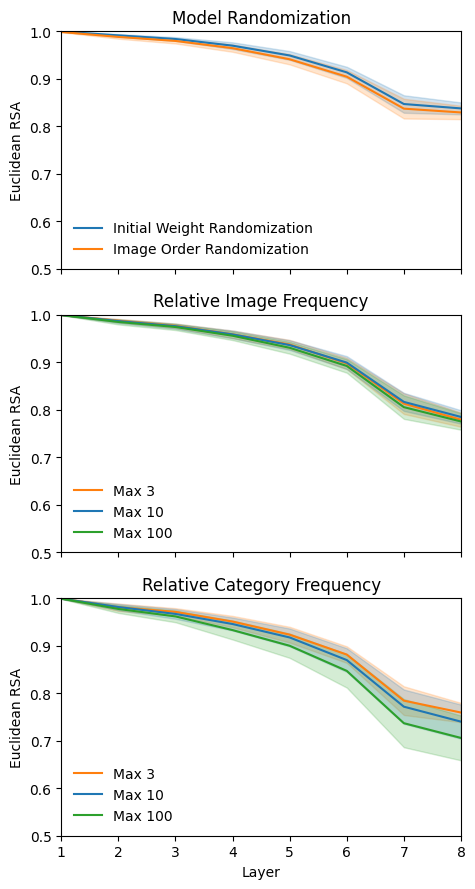

In [37]:
# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(plotWidth, plotHeight * 3), sharex=True)

# Create line plot for seed differences
axs[0].plot(
    [1, 2, 3, 4, 5, 6, 7, 8],
    shuffleDiffMeans,
    label="Initial Weight Randomization",
    color=part2Colors[0],
)
axs[0].fill_between(
    [1, 2, 3, 4, 5, 6, 7, 8],
    shuffleDiffMeans - shuffleDiffStd,
    shuffleDiffMeans + shuffleDiffStd,
    alpha=0.2,
    color=part2Colors[0],
)
axs[0].plot(
    [1, 2, 3, 4, 5, 6, 7, 8],
    weightDiffMeans,
    label="Image Order Randomization",
    color=part2Colors[1],
)
axs[0].fill_between(
    [1, 2, 3, 4, 5, 6, 7, 8],
    weightDiffMeans - weightDiffStd,
    weightDiffMeans + weightDiffStd,
    alpha=0.2,
    color=part2Colors[1],
)
axs[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7])
axs[0].set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8])
axs[0].set_xlim([1, 8])
axs[0].set_ylim([0.5, 1])
axs[0].set_ylabel("Euclidean RSA")
axs[0].legend()
axs[0].legend(loc="lower left", frameon=False)
axs[0].set_title("Model Randomization")

# Create line plot for item level differences
axs[1].plot(
    [1, 2, 3, 4, 5, 6, 7, 8],
    itemDiffMeans.loc[3].eucRsa,
    label="Max 3",
    color=part2Colors[1],
)
axs[1].fill_between(
    [1, 2, 3, 4, 5, 6, 7, 8],
    itemDiffMeans.loc[3].eucRsa - itemDiffStds.loc[3].eucRsa,
    itemDiffMeans.loc[3].eucRsa + itemDiffStds.loc[3].eucRsa,
    alpha=0.2,
    color=part2Colors[1],
)
axs[1].plot(
    [1, 2, 3, 4, 5, 6, 7, 8],
    itemDiffMeans.loc[10].eucRsa,
    label="Max 10",
    color=part2Colors[0],
)
axs[1].fill_between(
    [1, 2, 3, 4, 5, 6, 7, 8],
    itemDiffMeans.loc[10].eucRsa - itemDiffStds.loc[10].eucRsa,
    itemDiffMeans.loc[10].eucRsa + itemDiffStds.loc[10].eucRsa,
    alpha=0.2,
    color=part2Colors[0],
)
axs[1].plot(
    [1, 2, 3, 4, 5, 6, 7, 8],
    itemDiffMeans.loc[100].eucRsa,
    label="Max 100",
    color=part2Colors[2],
)
axs[1].fill_between(
    [1, 2, 3, 4, 5, 6, 7, 8],
    itemDiffMeans.loc[100].eucRsa - itemDiffStds.loc[100].eucRsa,
    itemDiffMeans.loc[100].eucRsa + itemDiffStds.loc[100].eucRsa,
    alpha=0.2,
    color=part2Colors[2],
)
axs[1].set_xticks([1, 2, 3, 4, 5, 6, 7, 8])
axs[1].set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8])
axs[1].set_xlim([1, 8])
axs[1].set_ylabel("Euclidean RSA")
axs[1].set_ylim([0.5, 1])
axs[1].legend(loc="lower left", frameon=False)
axs[1].set_title("Relative Image Frequency")

# Create line plot for category level differences
axs[2].plot(
    [1, 2, 3, 4, 5, 6, 7, 8],
    catDiffMeans.loc[3].eucRsa,
    label="Max 3",
    color=part2Colors[1],
)
axs[2].fill_between(
    [1, 2, 3, 4, 5, 6, 7, 8],
    catDiffMeans.loc[3].eucRsa - catDiffStds.loc[3].eucRsa,
    catDiffMeans.loc[3].eucRsa + catDiffStds.loc[3].eucRsa,
    alpha=0.2,
    color=part2Colors[1],
)
axs[2].plot(
    [1, 2, 3, 4, 5, 6, 7, 8],
    catDiffMeans.loc[10].eucRsa,
    label="Max 10",
    color=part2Colors[0],
)
axs[2].fill_between(
    [1, 2, 3, 4, 5, 6, 7, 8],
    catDiffMeans.loc[10].eucRsa - catDiffStds.loc[10].eucRsa,
    catDiffMeans.loc[10].eucRsa + catDiffStds.loc[10].eucRsa,
    alpha=0.2,
    color=part2Colors[0],
)
axs[2].plot(
    [1, 2, 3, 4, 5, 6, 7, 8],
    catDiffMeans.loc[100].eucRsa,
    label="Max 100",
    color=part2Colors[2],
)
axs[2].fill_between(
    [1, 2, 3, 4, 5, 6, 7, 8],
    catDiffMeans.loc[100].eucRsa - catDiffStds.loc[100].eucRsa,
    catDiffMeans.loc[100].eucRsa + catDiffStds.loc[100].eucRsa,
    alpha=0.2,
    color=part2Colors[2],
)
axs[2].set_xticks([1, 2, 3, 4, 5, 6, 7, 8])
axs[2].set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8])
axs[2].set_xlim([1, 8])
axs[2].set_xlabel("Layer")
axs[2].set_ylabel("Euclidean RSA")
axs[2].set_ylim([0.5, 1])
axs[2].legend(loc="lower left", frameon=False)
axs[2].set_title("Relative Category Frequency")

# Tight layout
plt.tight_layout()

plt.savefig("../outputs/masterOutput/manuscriptFigures/manipulationDiff.png")

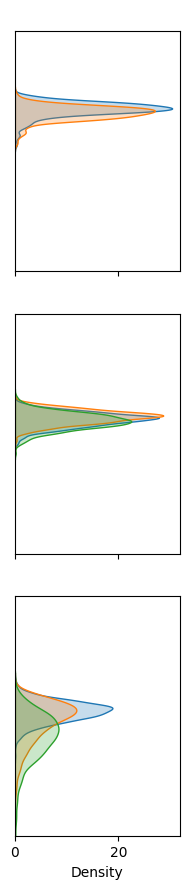

In [38]:
# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(2, plotHeight * 3), sharex=True)

fig.subplots_adjust(left=0)

# Seed diffs
sns.kdeplot(
    y=shuffleDiffs[:, :, 7].reshape(-1),
    ax=axs[0],
    color=part2Colors[0],
    label="Shuffle",
    fill=True,
)

sns.kdeplot(
    y=weightDiffs[:, :, 7].reshape(-1),
    ax=axs[0],
    color=part2Colors[1],
    label="Weight",
    fill=True,
)

# Set y axis to 1 to 0.5
axs[0].set_ylim(0.5, 1)
# Remove y axis label and ticks
axs[0].set_ylabel("")
axs[0].set_yticks([])
axs[0].set_title(" ")

# Item diffs
sns.kdeplot(
    y=itemCatDiffs.loc[
        (itemCatDiffs["type"] == "item")
        & (itemCatDiffs["layer"] == 7)
        & (itemCatDiffs["max"] == 3)
    ].eucRsa,
    ax=axs[1],
    color=part2Colors[0],
    label="Max 3",
    fill=True,
)

sns.kdeplot(
    y=itemCatDiffs.loc[
        (itemCatDiffs["type"] == "item")
        & (itemCatDiffs["layer"] == 7)
        & (itemCatDiffs["max"] == 10)
    ].eucRsa,
    ax=axs[1],
    color=part2Colors[1],
    label="Max 10",
    fill=True,
)

sns.kdeplot(
    y=itemCatDiffs.loc[
        (itemCatDiffs["type"] == "item")
        & (itemCatDiffs["layer"] == 7)
        & (itemCatDiffs["max"] == 100)
    ].eucRsa,
    ax=axs[1],
    color=part2Colors[2],
    label="Max 100",
    fill=True,
)

# Set y axis to 1 to 0.5
axs[1].set_ylim(0.5, 1)
# Remove y axis label and ticks
axs[1].set_ylabel("")
axs[1].set_yticks([])
axs[1].set_title(" ")


# Cat diffs
sns.kdeplot(
    y=itemCatDiffs.loc[
        (itemCatDiffs["type"] == "cat")
        & (itemCatDiffs["layer"] == 7)
        & (itemCatDiffs["max"] == 3)
    ].eucRsa,
    ax=axs[2],
    color=part2Colors[0],
    label="Max 3",
    fill=True,
)

sns.kdeplot(
    y=itemCatDiffs.loc[
        (itemCatDiffs["type"] == "cat")
        & (itemCatDiffs["layer"] == 7)
        & (itemCatDiffs["max"] == 10)
    ].eucRsa,
    ax=axs[2],
    color=part2Colors[1],
    label="Max 10",
    fill=True,
)

sns.kdeplot(
    y=itemCatDiffs.loc[
        (itemCatDiffs["type"] == "cat")
        & (itemCatDiffs["layer"] == 7)
        & (itemCatDiffs["max"] == 100)
    ].eucRsa,
    ax=axs[2],
    color=part2Colors[2],
    label="Max 100",
    fill=True,
)

# Set y axis to 1 to 0.5
axs[2].set_ylim(0.5, 1)
# Remove y axis label and ticks
axs[2].set_ylabel("")
axs[2].set_yticks([])
axs[2].set_title(" ")

# Tight layout
plt.tight_layout()

# Save figure
fig.savefig(
    "../outputs/masterOutput/manuscriptFigures/manipDensity.png", transparent=True
)

In [39]:
layerMapping = {
    0: -1,
    1: 1,
    2: 2,
    3: 3,
    4: -1,
    5: 4,
    6: 5,
    7: 6,
    8: -1,
    9: 7,
    10: 8,
    11: -1,
    12: -1,
    13: -1,
}
layersToKeep = [key for key, value in layerMapping.items() if not value == -1]
diffTypes = ["seedDiff", "itemDiff", "catDiff"]
# augType = 'maxAug'
augType = "random"

# Load baseline
baseline = pd.read_csv(
    f"../outputs/masterOutput/baseline/compiled/{augType}-seedDiff.csv", index_col=0
)
baseline["type"] = "seedDiff"

# Load item diffs and combine
tmp = pd.read_csv(
    f"../outputs/masterOutput/baseline/compiled/{augType}-itemDiff_max10.csv",
    index_col=0,
)
tmp["type"] = "itemDiff"
baseline = pd.concat([baseline, tmp])

# Load cat diffs and combine
tmp = pd.read_csv(
    f"../outputs/masterOutput/baseline/compiled/{augType}-catDiff_max1-10.csv",
    index_col=0,
)
tmp["type"] = "catDiff"
baseline = pd.concat([baseline, tmp])

# Only keep layers
baseline = baseline[baseline.layer.isin(layersToKeep)]
baseline["layer"] = baseline["layer"].apply(lambda x: layerMapping[x])
baseline.eucRsa = baseline.eucRsa**2

# Get layers
layers = baseline.layer.unique()

# Calculate means and CI by type and layer
baselineTypeMeans = baseline.groupby(["type", "layer"])["eucRsa"].mean(
    numeric_only=True
)
baselineTypeLowerCI = baselineTypeMeans - baseline.groupby(["type", "layer"])[
    "eucRsa"
].agg(pg.mad)
baselineTypeUpperCI = baselineTypeMeans + baseline.groupby(["type", "layer"])[
    "eucRsa"
].agg(pg.mad)

# Overall type mean
baselineMeans = baseline.groupby("layer")["eucRsa"].mean(numeric_only=True)
baselineLowerCI = baselineMeans - baseline.groupby("layer")["eucRsa"].agg(pg.mad)
baselineUpperCI = baselineMeans + baseline.groupby("layer")["eucRsa"].agg(pg.mad)

# Average eucRsa scores by type then layer
baselineTypeMeans

type      layer
catDiff   1        0.968835
          2        0.955444
          3        0.939117
          4        0.920004
          5        0.899120
          6        0.710375
          7        0.733506
          8        0.845178
itemDiff  1        0.968815
          2        0.956019
          3        0.939969
          4        0.921218
          5        0.904236
          6        0.725586
          7        0.738976
          8        0.843651
seedDiff  1        0.976083
          2        0.965034
          3        0.956769
          4        0.945849
          5        0.938626
          6        0.891635
          7        0.879919
          8        0.894535
Name: eucRsa, dtype: float64

In [40]:
baseline.groupby(["type", "layer"])["eucRsa"].agg(pg.mad)

type      layer
catDiff   1        0.004236
          2        0.005369
          3        0.007724
          4        0.010451
          5        0.011661
          6        0.036603
          7        0.032875
          8        0.011534
itemDiff  1        0.004140
          2        0.004963
          3        0.008058
          4        0.009879
          5        0.012023
          6        0.043381
          7        0.027826
          8        0.012807
seedDiff  1        0.017068
          2        0.022938
          3        0.026567
          4        0.031462
          5        0.033314
          6        0.058150
          7        0.065145
          8        0.054245
Name: eucRsa, dtype: float64

In [41]:
pg.anova(
    data=baseline,
    dv="eucRsa",
    between=["type", "layer"],
    detailed=True,
)

,Source,SS,DF,MS,F,p-unc,np2
0,type,24.402545,2.0,12.201272,7389.807368,0.0,0.144338
1,layer,136.553844,7.0,19.507692,11815.004431,0.0,0.485583
2,type * layer,26.310719,14.0,1.879337,1138.236956,0.0,0.153888
3,Residual,144.662319,87616.0,0.001651,NaN,NaN,NaN


In [42]:
baselineMeans

layer
1    0.975424
2    0.964189
3    0.955203
4    0.943555
5    0.935239
6    0.875718
7    0.866750
8    0.889941
Name: eucRsa, dtype: float64

In [43]:
baseline.groupby("layer")["eucRsa"].agg(pg.mad)

layer
1    0.016294
2    0.022238
3    0.026456
4    0.032302
5    0.036987
6    0.068620
7    0.076059
8    0.054870
Name: eucRsa, dtype: float64

In [44]:
seedDiffSims = pd.read_csv(
    "../outputs/masterOutput/similarities/seedDiff_allLayers.csv"
)
seedDiffSims.eucRsa = seedDiffSims.eucRsa**2

# No need to remap layers fully just shift 1 forward
seedDiffSims["layer"] = seedDiffSims["layer"] + 1

# Only keep first 8 layers
layersToKeep = [1, 2, 3, 4, 5, 6, 7, 8]
seedDiffSims = seedDiffSims[seedDiffSims.layer.isin(layersToKeep)]

layers = seedDiffSims.layer.unique()
# Sort layers
layers.sort()

# Calculate means and CIs
eucRsaSeedMeans = seedDiffSims.groupby("layer")["eucRsa"].agg(np.mean)
eucRsaSeedLowerCIs = eucRsaSeedMeans - seedDiffSims.groupby("layer")["eucRsa"].agg(
    pg.mad
)
eucRsaSeedUpperCIs = eucRsaSeedMeans + seedDiffSims.groupby("layer")["eucRsa"].agg(
    pg.mad
)

# Print means and CIs at each layer
print("Seed Diff average eucRsa scores by layer:")
for layer in layers:
    print(f"Layer: {layer}, eucRsa: {eucRsaSeedMeans[layer]}")
    print(
        f"Layer: {layer}, eucRsa CI: {eucRsaSeedLowerCIs[layer]} - {eucRsaSeedUpperCIs[layer]}"
    )

Seed Diff average eucRsa scores by layer:
Layer: 1, eucRsa: 0.9986989500775652
Layer: 1, eucRsa CI: 0.9981710365103448 - 0.9992268636447855
Layer: 2, eucRsa: 0.98857867449274
Layer: 2, eucRsa CI: 0.984922991362606 - 0.9922343576228739
Layer: 3, eucRsa: 0.9802678831644891
Layer: 3, eucRsa CI: 0.9751512709981063 - 0.9853844953308719
Layer: 4, eucRsa: 0.9651157461627563
Layer: 4, eucRsa CI: 0.9575997217408194 - 0.9726317705846932
Layer: 5, eucRsa: 0.9420786705284686
Layer: 5, eucRsa CI: 0.9314261946695653 - 0.9527311463873719
Layer: 6, eucRsa: 0.9054183472171758
Layer: 6, eucRsa CI: 0.8923019851703521 - 0.9185347092639996
Layer: 7, eucRsa: 0.8371676468440234
Layer: 7, eucRsa CI: 0.8158592906906849 - 0.858476002997362
Layer: 8, eucRsa: 0.8294101235532986
Layer: 8, eucRsa CI: 0.8159680969604481 - 0.842852150146149


In [45]:
seedDiffSims.groupby("layer")["eucRsa"].agg(pg.mad)

layer
1    0.000528
2    0.003656
3    0.005117
4    0.007516
5    0.010652
6    0.013116
7    0.021308
8    0.013442
Name: eucRsa, dtype: float64

In [46]:
seedDiffSims

,model1,model2,eucRsa,cka,layer
0,w1s0,w0s0,0.842940,0.872618,6
1,w2s0,w0s0,0.930062,0.926449,6
2,w2s0,w1s0,0.837260,0.876816,6
3,w3s0,w0s0,0.900026,0.913239,6
4,w3s0,w1s0,0.821347,0.878421,6
...,...,...,...,...,...
54445,w9s9,w4s9,0.843552,0.916260,8
54446,w9s9,w5s9,0.838033,0.916632,8
54447,w9s9,w6s9,0.851518,0.919125,8
54448,w9s9,w7s9,0.866493,0.918217,8


In [47]:
itemDiffSims = pd.read_csv(
    "../outputs/masterOutput/similarities/itemDiff_max10_allLayers.csv"
)
itemDiffSims.eucRsa = itemDiffSims.eucRsa**2

# No need to remap layers fully just shift 1 forward
itemDiffSims["layer"] = itemDiffSims["layer"] + 1

# Only keep first 8 layers
itemDiffSims = itemDiffSims[itemDiffSims.layer.isin(layersToKeep)]

# Calculate means and CIs
eucRsaItemMeans = itemDiffSims.groupby("layer")["eucRsa"].agg(np.mean)
eucRsaItemLowerCIs = eucRsaItemMeans - itemDiffSims.groupby("layer")["eucRsa"].agg(
    pg.mad
)
eucRsaItemUpperCIs = eucRsaItemMeans + itemDiffSims.groupby("layer")["eucRsa"].agg(
    pg.mad
)

# Print means and CIs at each layer
print("Item Diff average eucRsa scores by layer:")
for layer in layers:
    print(f"Layer: {layer}, eucRsa: {eucRsaItemMeans[layer]}")
    print(
        f"Layer: {layer}, eucRsa CI: {eucRsaItemLowerCIs[layer]} - {eucRsaItemUpperCIs[layer]}"
    )

Item Diff average eucRsa scores by layer:
Layer: 1, eucRsa: 0.9994126333962781
Layer: 1, eucRsa CI: 0.9992009498507507 - 0.9996243169418054
Layer: 2, eucRsa: 0.9866350278438802
Layer: 2, eucRsa CI: 0.982605295142562 - 0.9906647605451985
Layer: 3, eucRsa: 0.9758653776944212
Layer: 3, eucRsa CI: 0.9705337035655688 - 0.9811970518232735
Layer: 4, eucRsa: 0.9586426207196193
Layer: 4, eucRsa CI: 0.9504613336195258 - 0.9668239078197127
Layer: 5, eucRsa: 0.936149936889919
Layer: 5, eucRsa CI: 0.9258861155524706 - 0.9464137582273674
Layer: 6, eucRsa: 0.899262059621921
Layer: 6, eucRsa CI: 0.8856729351041566 - 0.9128511841396854
Layer: 7, eucRsa: 0.8165855788676476
Layer: 7, eucRsa CI: 0.7975772788198485 - 0.8355938789154467
Layer: 8, eucRsa: 0.7848963557220519
Layer: 8, eucRsa CI: 0.7707765244395257 - 0.799016187004578


In [48]:
itemDiffSims.groupby("layer")["eucRsa"].agg(pg.mad)

layer
1    0.000212
2    0.004030
3    0.005332
4    0.008181
5    0.010264
6    0.013589
7    0.019008
8    0.014120
Name: eucRsa, dtype: float64

In [49]:
catDiffSims = pd.read_csv(
    "../outputs/masterOutput/similarities/catDiff_max1-10_allLayers.csv"
)
catDiffSims.eucRsa = catDiffSims.eucRsa**2

# No need to remap layers fully just shift 1 forward
catDiffSims["layer"] = catDiffSims["layer"] + 1

# Only keep first 8 layers
catDiffSims = catDiffSims[catDiffSims.layer.isin(layersToKeep)]

# Calculate means and CIs
eucRsaCatMeans = catDiffSims.groupby("layer")["eucRsa"].agg(np.mean)
eucRsaCatLowerCIs = eucRsaCatMeans - catDiffSims.groupby("layer")["eucRsa"].agg(pg.mad)
eucRsaCatUpperCIs = eucRsaCatMeans + catDiffSims.groupby("layer")["eucRsa"].agg(pg.mad)

# Print means and CIs at each layer
print("Cat Diff average eucRsa scores by layer:")
for layer in layers:
    print(f"Layer: {layer}, eucRsa: {eucRsaCatMeans[layer]}")
    print(
        f"Layer: {layer}, eucRsa CI: {eucRsaCatLowerCIs[layer]} - {eucRsaCatUpperCIs[layer]}"
    )

Cat Diff average eucRsa scores by layer:
Layer: 1, eucRsa: 0.9989098968028641
Layer: 1, eucRsa CI: 0.998447712436568 - 0.9993720811691602
Layer: 2, eucRsa: 0.9813072950819896
Layer: 2, eucRsa CI: 0.9747115368231792 - 0.9879030533407999
Layer: 3, eucRsa: 0.9667894980020242
Layer: 3, eucRsa CI: 0.9565497995861415 - 0.9770291964179069
Layer: 4, eucRsa: 0.9455295602844469
Layer: 4, eucRsa CI: 0.9318366344422055 - 0.9592224861266883
Layer: 5, eucRsa: 0.9172529572305972
Layer: 5, eucRsa CI: 0.8984042075781928 - 0.9361017068830015
Layer: 6, eucRsa: 0.8696872213142719
Layer: 6, eucRsa CI: 0.8447844659282183 - 0.8945899767003255
Layer: 7, eucRsa: 0.771582769047553
Layer: 7, eucRsa CI: 0.7355188270950427 - 0.8076467110000632
Layer: 8, eucRsa: 0.7400931902740646
Layer: 8, eucRsa CI: 0.7041262493835152 - 0.776060131164614


In [50]:
catDiffSims.groupby("layer")["eucRsa"].agg(pg.mad)

layer
1    0.000462
2    0.006596
3    0.010240
4    0.013693
5    0.018849
6    0.024903
7    0.036064
8    0.035967
Name: eucRsa, dtype: float64

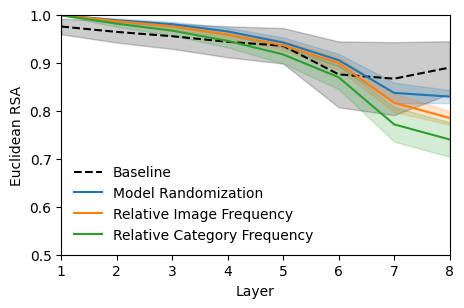

In [51]:
# Plot eucRSA scores by layer
fig = plt.figure(figsize=(plotWidth, plotHeight))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.8])

plotLayers = [1, 2, 3, 4, 5, 6, 7, 8]
# Plot baseline
ax.plot(plotLayers, baselineMeans, color="black", label="Baseline", linestyle="--")
ax.fill_between(plotLayers, baselineLowerCI, baselineUpperCI, color="black", alpha=0.2)

# Plot seed diffs
ax.plot(plotLayers, eucRsaSeedMeans, color=part2Colors[0], label="Model Randomization")
ax.fill_between(
    plotLayers, eucRsaSeedLowerCIs, eucRsaSeedUpperCIs, color=part2Colors[0], alpha=0.2
)

# Plot item diffs
ax.plot(
    plotLayers, eucRsaItemMeans, color=part2Colors[1], label="Relative Image Frequency"
)
ax.fill_between(
    plotLayers, eucRsaItemLowerCIs, eucRsaItemUpperCIs, color=part2Colors[1], alpha=0.2
)

# Plot cat diffs
ax.plot(
    plotLayers,
    eucRsaCatMeans,
    color=part2Colors[2],
    label="Relative Category Frequency",
)
ax.fill_between(
    plotLayers, eucRsaCatLowerCIs, eucRsaCatUpperCIs, color=part2Colors[2], alpha=0.2
)

# Add legend on bottom right
ax.legend(loc="lower left", frameon=False)

# Add labels
ax.set_xlabel("Layer")
ax.set_ylabel("Euclidean RSA")

# Set axis limits
ax.set_xlim(1, 8)
ax.set_ylim(0.5, 1)
fig.show()

# Save figure
fig.savefig("../outputs/masterOutput/manuscriptFigures/diffByLayer.png")

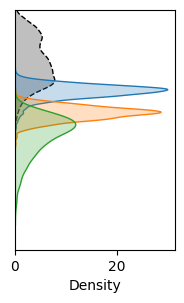

In [52]:
fig = plt.figure(figsize=(2, plotHeight))
fig.subplots_adjust(left=0)
ax = fig.add_axes([0.15, 0.15, 0.8, 0.8])

sns.kdeplot(
    y=baseline[baseline.layer == 8].eucRsa,
    ax=ax,
    color="black",
    label="Baseline",
    fill=True,
    linestyle="--",
)

sns.kdeplot(
    y=seedDiffSims[seedDiffSims.layer == 8].eucRsa,
    ax=ax,
    color=part2Colors[0],
    label="Model Randomization",
    fill=True,
)

sns.kdeplot(
    y=itemDiffSims[itemDiffSims.layer == 8].eucRsa,
    ax=ax,
    color=part2Colors[1],
    label="Relative Item Frequency",
    fill=True,
)

sns.kdeplot(
    y=catDiffSims[catDiffSims.layer == 8].eucRsa,
    ax=ax,
    color=part2Colors[2],
    label="Relative Category Frequency",
    fill=True,
)

# Set y axis to 1 to 0.5
ax.set_ylim(0.5, 1)
# Remove y axis label and ticks
ax.set_ylabel("")
ax.set_yticks([])

# Save figure
fig.savefig(
    "../outputs/masterOutput/manuscriptFigures/diffDensity.png", transparent=True
)

In [53]:
# KDE plot of baseline
sns.kdeplot(
    baseline[baseline.layer == 8].eucRsa,
    ax=ax,
    color="black",
    label="Baseline",
    linestyle="--",
)


# Filter baseline for layer 8
baseline[baseline.layer == 8].eucRsa

0    0.946575
1    0.826373
2    0.933143
3    0.858755
4    0.897372
       ...   
5    0.836043
6    0.849389
7    0.831749
8    0.852014
9    0.853634
Name: eucRsa, Length: 10910, dtype: float64

In [54]:
seedDiffSims

,model1,model2,eucRsa,cka,layer
0,w1s0,w0s0,0.842940,0.872618,6
1,w2s0,w0s0,0.930062,0.926449,6
2,w2s0,w1s0,0.837260,0.876816,6
3,w3s0,w0s0,0.900026,0.913239,6
4,w3s0,w1s0,0.821347,0.878421,6
...,...,...,...,...,...
54445,w9s9,w4s9,0.843552,0.916260,8
54446,w9s9,w5s9,0.838033,0.916632,8
54447,w9s9,w6s9,0.851518,0.919125,8
54448,w9s9,w7s9,0.866493,0.918217,8


In [55]:
itemDiffSims

,model1,model2,eucRsa,cka,layer
0,model36,model34,0.924680,0.925453,4
1,model36,model40,0.949301,0.932850,4
2,model36,model3,0.970168,0.943451,4
3,model36,model30,0.965642,0.946727,4
4,model36,model25,0.944060,0.932279,4
...,...,...,...,...,...
13470,model19,model5,0.821051,0.874877,7
13471,model19,model22,0.805363,0.867281,7
13472,model42,model5,0.842844,0.877564,7
13473,model42,model22,0.826818,0.879302,7


In [56]:
catDiffSims

,model1,model2,eucRsa,cka,layer
0,model36,model34,0.627087,0.865501,8
1,model36,model40,0.685661,0.864813,8
2,model36,model3,0.599198,0.844799,8
3,model36,model30,0.607126,0.853888,8
4,model36,model25,0.745456,0.879928,8
...,...,...,...,...,...
12245,model19,model5,0.943231,0.927912,4
12246,model19,model22,0.955204,0.943815,4
12247,model42,model5,0.924206,0.926444,4
12248,model42,model22,0.960769,0.942534,4


In [57]:
pg.anova(data=baseline, dv="eucRsa", between="type")

,Source,ddof1,ddof2,F,p-unc,np2
0,type,2,87637,3495.409211,0.0,0.073877


In [58]:
layerToCompare = 8
pg.ttest(
    seedDiffSims.loc[seedDiffSims["layer"] == layerToCompare].eucRsa,
    catDiffSims.loc[catDiffSims["layer"] == layerToCompare].eucRsa,
    paired=False,
)

/data/venv/research2/lib/python3.8/site-packages/pingouin/bayesian.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df) ** (-(df + 1) / 2) / integr)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,75.683365,1316.425075,two-sided,0.0,"[0.09, 0.09]",3.899556,inf,1.0


In [59]:
bigLayers = {
    "resnet50": [6, 142, 175],
    "resnet101": [6, 312, 345],
    "vgg16": [3, 10, 21],
    "vgg19": [3, 11, 24],
}
models = ["resnet50", "resnet101", "vgg16", "vgg19"]
bigRDMs = {}
for model in models:
    # Load representations
    bigRDMs[model] = []
    for layer in bigLayers[model]:
        reps = np.load(
            f"../outputs/masterOutput/representations/{model}/test/{model}l{layer}.npy"
        )

        # Create and save RDMs
        bigRDMs[model].append(analysis.preprocess_eucRsaNumba(reps))

# Create similarity matrix between RDMs
bigSims = np.zeros((len(models), len(models), len(bigLayers["resnet50"])))

for i, model1 in enumerate(models):
    for j, model2 in enumerate(models):
        for k, layer in enumerate(bigLayers["resnet50"]):
            bigSims[i, j, k] = (
                analysis.do_rsaNumba(bigRDMs[model1][k], bigRDMs[model2][k]) ** 2
            )

In [60]:
# Load baseline similarities
bigBaseline = np.zeros((len(models), 1, len(bigLayers["resnet50"])))
bigBaselineStd = np.zeros((len(models), 1, len(bigLayers["resnet50"])))
allBaseline = pd.DataFrame()
for i, model in enumerate(models):
    for k, layer in enumerate(bigLayers[model]):
        baseline = pd.read_csv(
            f"../outputs/masterOutput/baseline/{model}l{layer}-random.csv"
        )
        # Add layer column
        baseline["layer"] = bigLayers[model].index(layer)

        allBaseline = pd.concat([allBaseline, baseline])

        bigBaseline[i, 0, k] = baseline["eucRsa"].mean()
        bigBaselineStd[i, 0, k] = baseline["eucRsa"].agg(pg.mad)

# Calculate allBaseline for each layer
allBaselineMeans = allBaseline.groupby("layer")["eucRsa"].agg(np.mean)
allBaselineLowerCI = allBaselineMeans - allBaseline.groupby("layer")["eucRsa"].agg(
    pg.mad
)
allBaselineUpperCI = allBaselineMeans + allBaseline.groupby("layer")["eucRsa"].agg(
    pg.mad
)

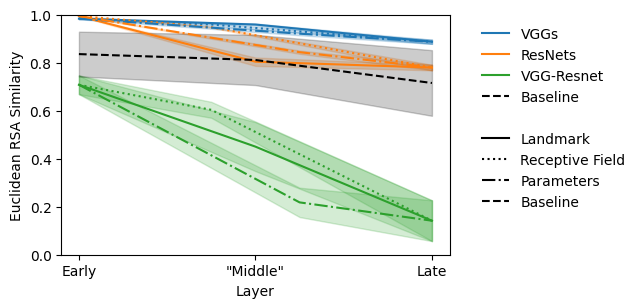

In [61]:
def bigModelSimPlot(ax, bigModelSims, linestyle="solid", midoffset=0):
    # Calculate MAD across repeats
    bigModelSimsMAD = pg.mad(bigModelSims, axis=0)  # (layer, model, model)

    # Calculate mean across repeats
    bigModelSimsMean = np.mean(bigModelSims, axis=0)

    # Extract VGG cells and ResNet cells separately
    vggSims = bigModelSimsMean[:, 0, 1]
    vggMAD = bigModelSimsMAD[:, 0, 1]
    resnetSims = bigModelSimsMean[:, 2, 3]
    resnetMAD = bigModelSimsMAD[:, 2, 3]

    # Extract the cross architecture cells
    crossSims = bigModelSims[:, :, 0, 2]
    crossSims = np.concatenate((crossSims, bigModelSims[:, :, 1, 2]))
    crossSims = np.concatenate((crossSims, bigModelSims[:, :, 0, 3]))
    crossSims = np.concatenate((crossSims, bigModelSims[:, :, 1, 3]))
    crossSimMean = np.mean(crossSims, axis=0)
    crossSimMAD = pg.mad(crossSims, axis=0)

    # Plot VGGs
    ax.plot(
        [1, 2 + midoffset, 3],
        vggSims,
        label="VGGs",
        color=part2Colors[0],
        linestyle=linestyle,
    )
    ax.fill_between(
        [1, 2 + midoffset, 3],
        vggSims - vggMAD,
        vggSims + vggMAD,
        alpha=0.2,
        color=part2Colors[0],
    )

    # Plot ResNets
    ax.plot(
        [1, 2 + midoffset, 3],
        resnetSims,
        label="ResNets",
        color=part2Colors[1],
        linestyle=linestyle,
    )
    ax.fill_between(
        [1, 2 + midoffset, 3],
        resnetSims - resnetMAD,
        resnetSims + resnetMAD,
        alpha=0.2,
        color=part2Colors[1],
    )

    # Plot cross architecture
    ax.plot(
        [1, 2 + midoffset, 3],
        crossSimMean,
        label="VGG-Resnet",
        color=part2Colors[2],
        linestyle=linestyle,
    )
    ax.fill_between(
        [1, 2 + midoffset, 3],
        crossSimMean - crossSimMAD,
        crossSimMean + crossSimMAD,
        alpha=0.2,
        color=part2Colors[2],
    )


# Plot eucRsa at each layer for each model
fig = plt.figure(figsize=(plotWidth, plotHeight))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.8])

# Load bigModelSims_eucRsa.npy
bigModelSims = np.load(
    "../outputs/masterOutput/similarities/bigModelSims_eucRsa_landmark.npy"
)

bigModelSimPlot(ax, bigModelSims, linestyle="solid", midoffset=0)

bigModelSims = np.load(
    "../outputs/masterOutput/similarities/bigModelSims_eucRsa_rf.npy"
)

bigModelSimPlot(ax, bigModelSims, linestyle="dotted", midoffset=-0.25)

bigModelSims = np.load(
    "../outputs/masterOutput/similarities/bigModelSims_eucRsa_param.npy"
)

bigModelSimPlot(ax, bigModelSims, linestyle="dashdot", midoffset=0.25)

# Add baseline
ax.plot([1, 2, 3], allBaselineMeans, label="Baseline", color="black", linestyle="--")
ax.fill_between(
    [1, 2, 3], allBaselineLowerCI, allBaselineUpperCI, alpha=0.2, color="black"
)

# Change y-axis to 1, 0.5
ax.set_ylim(0, 1)
ax.set_ylabel("Euclidean RSA Similarity")

# Change x axis to ready ['early', 'mid', 'late']
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["Early", '"Middle"', "Late"])
ax.set_xlabel("Layer")

# Create custom legend handles and labels
vgg_line = mlines.Line2D([], [], color=part2Colors[0], label="VGGs", linestyle="solid")
resnet_line = mlines.Line2D(
    [], [], color=part2Colors[1], label="ResNets", linestyle="solid"
)
cross_line = mlines.Line2D(
    [], [], color=part2Colors[2], label="VGG-Resnet", linestyle="solid"
)
baseline_line = mlines.Line2D(
    [], [], color="black", label="Baseline", linestyle="dashed"
)
none_line = mlines.Line2D([], [], color="white", label="")
solid_line = mlines.Line2D([], [], color="black", label="Landmark", linestyle="solid")
dotted_line = mlines.Line2D(
    [], [], color="black", label="Receptive Field", linestyle="dotted"
)
dashdot_line = mlines.Line2D(
    [], [], color="black", label="Parameters", linestyle="dashdot"
)
dashhed_line = mlines.Line2D(
    [], [], color="black", label="Baseline", linestyle="dashed"
)

# Create legend
ax.legend(
    handles=[
        vgg_line,
        resnet_line,
        cross_line,
        baseline_line,
        none_line,
        solid_line,
        dotted_line,
        dashdot_line,
        dashhed_line,
    ],
    frameon=False,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
)

# Save figure
fig.savefig(
    "../outputs/masterOutput/manuscriptFigures/bigDiffByLayer.png",
    bbox_inches=Bbox(np.array([[0, 0], [plotWidth + 1.6, plotHeight]])),
)

In [62]:
tmp = itemCatDiffs.loc[itemCatDiffs["type"] == "item"]
# Get std of eucRsa at each layer
eucRsaStd = tmp["eucRsa"].std()

# # Add layer specific noise to eucRsa
# for layer in eucRsaStd.index:
#     # Get rows for layer
#     layerRows = tmp.loc[tmp["layer"] == layer]

#     # Generate random noise with the same SD
#     noise = np.random.normal(0, 2 * eucRsaStd[layer], len(layerRows))
#     # Add noise to eucRsa
#     tmp.loc[tmp["layer"] == layer, "eucRsa"] = layerRows.loc[:, "eucRsa"] + noise

# Generate random noise with the same SD
# noise = np.random.normal(0, eucRsaStd, len(tmp))
# # Add noise to eucRsa
# tmp.loc[:,'eucRsa'] = tmp.loc[:, 'eucRsa'] + noise

pg.anova(
    data=tmp,
    dv="eucRsa",
    between=["layer", "max"],
    detailed=True,
)

,Source,SS,DF,MS,F,p-unc,np2
0,layer,173.918945,7,24.845564,146183.373951,0.000000e+00,0.972094
1,max,0.135248,2,0.067624,397.878708,3.180265e-171,0.026374
2,layer * max,0.080773,14,0.005769,33.945749,9.920375e-92,0.015920
3,Residual,4.992793,29376,0.000170,NaN,NaN,NaN


In [63]:
pg.pairwise_tests(
    data=tmp,
    dv="eucRsa",
    between=["max"],
    padjust="bonf",
)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,max,3,10,False,True,-0.932418,19598.0,two-sided,0.351132,1.000000,bonf,0.025,-0.013320
1,max,3,100,False,True,3.495701,19598.0,two-sided,0.000474,0.001422,bonf,7.21,0.049937
2,max,10,100,False,True,4.466838,19598.0,two-sided,0.000008,0.000024,bonf,342.301,0.063810


In [64]:
model = tf.keras.applications.VGG16(weights="imagenet", include_top=True)

rf = 1
stride = 1
modelLayers = [
    layer for layer in model.layers if "conv" in layer.name or "pool" in layer.name
]
for i in range(len(modelLayers)):
    kl = (
        modelLayers[i].kernel_size[0]
        if "conv" in modelLayers[i].name
        else modelLayers[i].pool_size[0]
    ) - 1

    # Multiply with current stride
    kl *= stride

    # Add to rf
    rf += kl

    # Update stride
    stride *= modelLayers[i].strides[0]

    # Print info
    print(
        f"Layer {i}: {modelLayers[i].name} kl = {kl+1}, stride = {modelLayers[i].strides[0]} - Current RF {rf} Cumulative stride {stride}"
    )

Layer 0: block1_conv1 kl = 3, stride = 1 - Current RF 3 Cumulative stride 1
Layer 1: block1_conv2 kl = 3, stride = 1 - Current RF 5 Cumulative stride 1
Layer 2: block1_pool kl = 2, stride = 2 - Current RF 6 Cumulative stride 2
Layer 3: block2_conv1 kl = 5, stride = 1 - Current RF 10 Cumulative stride 2
Layer 4: block2_conv2 kl = 5, stride = 1 - Current RF 14 Cumulative stride 2
Layer 5: block2_pool kl = 3, stride = 2 - Current RF 16 Cumulative stride 4
Layer 6: block3_conv1 kl = 9, stride = 1 - Current RF 24 Cumulative stride 4
Layer 7: block3_conv2 kl = 9, stride = 1 - Current RF 32 Cumulative stride 4
Layer 8: block3_conv3 kl = 9, stride = 1 - Current RF 40 Cumulative stride 4
Layer 9: block3_pool kl = 5, stride = 2 - Current RF 44 Cumulative stride 8
Layer 10: block4_conv1 kl = 17, stride = 1 - Current RF 60 Cumulative stride 8
Layer 11: block4_conv2 kl = 17, stride = 1 - Current RF 76 Cumulative stride 8
Layer 12: block4_conv3 kl = 17, stride = 1 - Current RF 92 Cumulative stride 8

2023-10-01 11:51:32.563424: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.


In [65]:
model = tf.keras.applications.VGG19(weights="imagenet")

rf = 1
stride = 1
modelLayers = [
    layer for layer in model.layers if "conv" in layer.name or "pool" in layer.name
]
for i in range(len(modelLayers)):
    kl = (
        modelLayers[i].kernel_size[0]
        if "conv" in modelLayers[i].name
        else modelLayers[i].pool_size[0]
    ) - 1

    # Multiply with current stride
    kl *= stride

    # Add to rf
    rf += kl

    # Update stride
    stride *= modelLayers[i].strides[0]

    # Print info
    print(
        f"Layer {i}: {modelLayers[i].name} kl = {kl+1}, stride = {modelLayers[i].strides[0]} - Current RF {rf} Cumulative stride {stride}"
    )

Layer 0: block1_conv1 kl = 3, stride = 1 - Current RF 3 Cumulative stride 1
Layer 1: block1_conv2 kl = 3, stride = 1 - Current RF 5 Cumulative stride 1
Layer 2: block1_pool kl = 2, stride = 2 - Current RF 6 Cumulative stride 2
Layer 3: block2_conv1 kl = 5, stride = 1 - Current RF 10 Cumulative stride 2
Layer 4: block2_conv2 kl = 5, stride = 1 - Current RF 14 Cumulative stride 2
Layer 5: block2_pool kl = 3, stride = 2 - Current RF 16 Cumulative stride 4
Layer 6: block3_conv1 kl = 9, stride = 1 - Current RF 24 Cumulative stride 4
Layer 7: block3_conv2 kl = 9, stride = 1 - Current RF 32 Cumulative stride 4
Layer 8: block3_conv3 kl = 9, stride = 1 - Current RF 40 Cumulative stride 4
Layer 9: block3_conv4 kl = 9, stride = 1 - Current RF 48 Cumulative stride 4
Layer 10: block3_pool kl = 5, stride = 2 - Current RF 52 Cumulative stride 8
Layer 11: block4_conv1 kl = 17, stride = 1 - Current RF 68 Cumulative stride 8
Layer 12: block4_conv2 kl = 17, stride = 1 - Current RF 84 Cumulative stride 8


2023-10-01 11:51:36.559011: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.


In [66]:
rf = 1
stride = 1
modelLayers = [
    layer for layer in model.layers if "_conv" in layer.name or "_pool" in layer.name
]
for i in range(len(modelLayers)):
    kl = (
        modelLayers[i].kernel_size[0]
        if "conv" in modelLayers[i].name
        else modelLayers[i].pool_size[0]
    ) - 1

    # Multiply with current stride
    kl *= stride

    # Add to rf
    rf += kl

    # Update stride
    stride *= modelLayers[i].strides[0]

    # Print info
    print(
        f"Layer {i}: {modelLayers[i].name} kl = {kl+1}, stride = {modelLayers[i].strides[0]} - Current RF {rf} Cumulative stride {stride}"
    )

Layer 0: block1_conv1 kl = 3, stride = 1 - Current RF 3 Cumulative stride 1
Layer 1: block1_conv2 kl = 3, stride = 1 - Current RF 5 Cumulative stride 1
Layer 2: block1_pool kl = 2, stride = 2 - Current RF 6 Cumulative stride 2
Layer 3: block2_conv1 kl = 5, stride = 1 - Current RF 10 Cumulative stride 2
Layer 4: block2_conv2 kl = 5, stride = 1 - Current RF 14 Cumulative stride 2
Layer 5: block2_pool kl = 3, stride = 2 - Current RF 16 Cumulative stride 4
Layer 6: block3_conv1 kl = 9, stride = 1 - Current RF 24 Cumulative stride 4
Layer 7: block3_conv2 kl = 9, stride = 1 - Current RF 32 Cumulative stride 4
Layer 8: block3_conv3 kl = 9, stride = 1 - Current RF 40 Cumulative stride 4
Layer 9: block3_conv4 kl = 9, stride = 1 - Current RF 48 Cumulative stride 4
Layer 10: block3_pool kl = 5, stride = 2 - Current RF 52 Cumulative stride 8
Layer 11: block4_conv1 kl = 17, stride = 1 - Current RF 68 Cumulative stride 8
Layer 12: block4_conv2 kl = 17, stride = 1 - Current RF 84 Cumulative stride 8


In [67]:
# Clear session
del model
tf.keras.backend.clear_session()
model = tf.keras.applications.ResNet101(weights="imagenet", include_top=True)

totalParam = model.count_params()

paramCount = 0
for layer in model.layers:
    # Get parameters in this layer
    paramCount += layer.count_params()
    # Get layer name
    layerName = layer.name

    # Print
    print(
        f"Layer: {layerName}, Parameters: {layer.count_params()}, Total: {paramCount/totalParam}"
    )

Layer: input_1, Parameters: 0, Total: 0.0
Layer: conv1_pad, Parameters: 0, Total: 0.0
Layer: conv1_conv, Parameters: 9472, Total: 0.0002118675534325854
Layer: conv1_bn, Parameters: 256, Total: 0.00021759370352535798
Layer: conv1_relu, Parameters: 0, Total: 0.00021759370352535798
Layer: pool1_pad, Parameters: 0, Total: 0.00021759370352535798
Layer: pool1_pool, Parameters: 0, Total: 0.00021759370352535798
Layer: conv2_block1_1_conv, Parameters: 4160, Total: 0.0003106436425329124
Layer: conv2_block1_1_bn, Parameters: 256, Total: 0.00031636979262568497
Layer: conv2_block1_1_relu, Parameters: 0, Total: 0.00031636979262568497
Layer: conv2_block1_2_conv, Parameters: 36928, Total: 0.0011423669435081294
Layer: conv2_block1_2_bn, Parameters: 256, Total: 0.001148093093600902
Layer: conv2_block1_2_relu, Parameters: 0, Total: 0.001148093093600902
Layer: conv2_block1_0_conv, Parameters: 16640, Total: 0.0015202928496311197
Layer: conv2_block1_3_conv, Parameters: 16640, Total: 0.0018924926056613372
La

In [68]:
middleRFLayers = {  # Target receptive field: 112
    "vgg16": "block4_pool",  # RF 124
    "vgg19": "block4_pool",  # RF 124
    "resnet50": "conv4_block1_out",  # RF 131
    "resnet101": "conv4_block1_out",  # RF 131
}
# ResNets are done using receptivefield package https://github.com/google-research/receptive_field.git

middleLandmarkLayers = {
    "vgg16": "block4_pool",
    "vgg19": "block4_pool",
    "resnet50": "conv5_block2_out",
    "resnet101": "conv5_block2_out",
}

middleParamLayers = {
    "vgg16": "fc1",
    "vgg19": "fc1",
    "resnet50": "conv5_block1_out",
    "resnet101": "conv4_block19_out",
}